In [98]:
# === CELL 0: GLOBALS (bắt buộc) ===
import os, json, re, math, numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from model.cnn import miniCNN
from model.mtl_cnn import mtl_cnn_v1
from model.mobilenet_v4 import CustomMobileNetV4 as MobileNetV4
from model.efficientnet_b0 import CustomEfficientNetB0
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
# 0.1) Class names chuẩn (đặt đúng thứ tự bạn muốn báo cáo)
CLASS_NAMES = [
    "Banh beo","Banh bot loc","Banh can","Banh canh","Banh chung","Banh cuon","Banh duc","Banh gio",
    "Banh khot","Banh mi","Banh pia","Banh tet","Banh trang nuong","Banh xeo","Bun bo Hue","Bun dau mam tom",
    "Bun mam","Bun rieu","Bun thit nuong","Ca kho to","Canh chua","Cao lau","Chao long","Com tam",
    "Goi cuon","Hu tieu","Mi quang","Nem chua","Pho","Xoi xeo","banh_da_lon","banh_tieu","banh_trung_thu"
]
NUM_CLASSES = len(CLASS_NAMES)

# 0.2) Thư mục dữ liệu & output
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"
TEST_DIR = f"{ROOT}/Test"
RUNS_DIR = "./Runs"       # thư mục cha chứa các run
IMAGES_DIR = "./images"
os.makedirs(IMAGES_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# alias để các cell cũ không lỗi assert "device"
device = DEVICE
IMG_SIZE = 224
BATCH = 64
NUM_WORKERS = 8

In [99]:
# === CELL 1: BUILD TEST LOADER ===
def build_test_loader(test_dir: str = TEST_DIR, img_size: int = IMG_SIZE, batch_size: int = BATCH):
    """Tạo DataLoader test. Trả về (loader, dataset)."""
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        # nếu lúc train có Normalize(...) thì thêm vào đúng mean/std tại đây
    ])
    ds = datasets.ImageFolder(test_dir, transform=tfm)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers= NUM_WORKERS, pin_memory=True)
    return loader, ds

# cache 1 lần để tái dùng
_TEST_CACHE = {}

def make_test_loader_safe():
    """Dùng TEST_DIR/TEST_TFM/BATCH (global). Không phụ thuộc root_test/test_transform cục bộ."""
    key = (TEST_DIR, IMG_SIZE, BATCH)
    if key not in _TEST_CACHE:
        loader, ds = build_test_loader(TEST_DIR, IMG_SIZE, BATCH)
        _TEST_CACHE[key] = (loader, ds)
    return _TEST_CACHE[key]


=== Vẽ ROC: miniCNN ===


C:\Users\Admin\AppData\Local\Temp\ipykernel_24036\1106938119.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt, map_location=device)


ValueError: too many values to unpack (expected 2)

In [100]:
# === CELL 2: MODEL FACTORY & CHECKPOINT LOADER (AN TOÀN) ===
def model_auto(run_name:str, num_classes:int=NUM_CLASSES):
    n = run_name.lower()
    if "mobilenetv4" in n or "mobile" in n:
        return MobileNetV4(num_classes=num_classes)
    if "efficientnet" in n or "b0" in n:
        return CustomEfficientNetB0(num_classes=num_classes)
  




    return mtl_cnn_v1(num_classes=num_classes)

def pick_checkpoint(run_path: str):
    """Ưu tiên best.mtl, sau đó *.mtl, *.pt, *.pth trong folder checkpoints/"""
    ckdir = os.path.join(run_path, "checkpoints")
    cand = []
    if os.path.isdir(ckdir):
        for f in os.listdir(ckdir):
            if f.lower().endswith((".mtl",".pt",".pth")):
                cand.append(os.path.join(ckdir,f))
    # ưu tiên best.*
    cand = sorted(cand, key=lambda p: (0 if os.path.basename(p).lower().startswith("best") else 1, p))
    return cand[0] if cand else None

def load_checkpoint(model, ckpt_path, device=DEVICE):
    state = torch.load(ckpt_path, map_location=device)
    # hỗ trợ nhiều định dạng state
    if isinstance(state, dict) and "state_dict" in state:
        sd = state["state_dict"]
    elif isinstance(state, dict) and "net" in state:
        sd = state["net"]
    else:
        sd = state
    # bỏ tiền tố 'module.' nếu có
    new_sd = {}
    for k, v in sd.items():
        nk = k.replace("module.", "")
        new_sd[nk] = v
    missing, unexpected = model.load_state_dict(new_sd, strict=False)
    if missing:   print("[load] missing keys:", missing)
    if unexpected:print("[load] unexpected keys:", unexpected)
    model.to(device).eval()
    return model

In [101]:
# === CELL 3: COLLECT LOGITS (ỔN ĐỊNH NHÃN) ===
@torch.no_grad()
def collect_logits(model, loader, device=DEVICE, class_names=CLASS_NAMES):
    # Nếu thứ tự dataset khác CLASS_NAMES -> remap
    ds = loader.dataset
    remap = None
    if hasattr(ds, "classes"):
        ds_names = list(ds.classes)
        name2idx = {n:i for i,n in enumerate(class_names)}
        # map index dataset -> index chuẩn
        remap = {i: name2idx[n] for i,n in enumerate(ds_names)}
    y_true, y_pred, y_prob = [], [], []
    for x, y in loader:
        x = x.to(device)
        if remap is not None:
            y = torch.as_tensor([remap[int(t)] for t in y], dtype=torch.long)
        logits = model(x).detach().cpu()
        prob = F.softmax(logits, dim=1).numpy()
        pred = prob.argmax(1)
        y_true.append(y.numpy())
        y_pred.append(pred)
        y_prob.append(prob)
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_prob)

In [102]:
# === CELL 4: PLOT CONFUSION MATRIX ===
def plot_confusion_matrix(y_true, y_pred, class_names, title, out_png):
    cm_counts = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    cm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    THRESHOLD = 0.10  # 10%
    fig, ax = plt.subplots(figsize=(12, 10), dpi=180)
    sns.heatmap(cm, vmin=0, vmax=1, cmap="Blues", square=True, cbar_kws={'shrink': .7},
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            show = (i == j) or (cm[i, j] >= THRESHOLD)
            if show and cm_counts[i, j] > 0:
                ax.text(j+0.5, i+0.5, f"{cm[i,j]*100:.0f}%\n({cm_counts[i,j]})",
                        ha="center", va="center", fontsize=7, color="black")
    ax.set_xlabel("Predicted", fontsize=11)
    ax.set_ylabel("True", fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_png)

In [103]:
# === CELL 5 
def _read_cfg_size_batch(run_path, default_img=IMG_SIZE, default_bs=BATCH):
    """Đọc img_size, batch_size từ config.json (nếu có); fallback về global."""
    img_size, batch_size = default_img, default_bs
    cfg_path = os.path.join(run_path, "config.json")
    if os.path.isfile(cfg_path):
        try:
            import json
            with open(cfg_path, "r", encoding="utf-8") as f:
                cfg = json.load(f)
            # linh hoạt tên khóa
            for k in ["img_size", "image_size", "input_size", "IMG_SIZE"]:
                if k in cfg: img_size = int(cfg[k]) if isinstance(cfg[k], (int, float)) else img_size
            for k in ["batch_size", "BATCH", "bs"]:
                if k in cfg: batch_size = int(cfg[k]) if isinstance(cfg[k], (int, float)) else batch_size
        except Exception as e:
            print(f"[warn] Không đọc được config.json: {e}")
    return img_size, batch_size

In [104]:
# ==== CELL: Benchmark tốc độ & tài nguyên (FPS, ms/ảnh, Params, Size) ====
import os, io, time
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

# ---------- 1) Tiện ích kích thước mô hình ----------
def estimate_state_size_bytes(state_dict_or_model):
    """
    Ước lượng size (bytes) của state_dict (ưu tiên) hoặc toàn bộ tham số model.
    """
    try:
        # Nếu truyền vào là state_dict
        tensors = list(state_dict_or_model.values())
    except Exception:
        # Ngược lại: lấy từ model.parameters()
        tensors = [p.data for p in state_dict_or_model.parameters()]

    total = 0
    for t in tensors:
        if isinstance(t, torch.Tensor):
            total += t.numel() * t.element_size()
    return int(total)

def file_size_bytes(path):
    try:
        return os.path.getsize(path)
    except Exception:
        return None

# ---------- 2) Đếm tham số ----------
def count_params(model, trainable_only=False):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

# ---------- 3) Benchmark 1 model ----------
@torch.no_grad()
def benchmark_model(model, device, input_size=(1, 3, 224, 224), repeat=50, warmup=10):
    """
    Trả về dict: {'ms_per_img', 'FPS', 'params', 'state_size_mb'}.
    - input_size: (B, C, H, W), nên để B=1 để so tốc độ/ảnh.
    - repeat: số lần lặp đo; warmup: số lần warm-up bỏ qua thời gian.
    """
    model.eval().to(device)
    x = torch.randn(*input_size, device=device)

    # warm-up để ổn định kernel/layernorm/cuDNN
    for _ in range(warmup):
        _ = model(x)
    if device.type == "cuda":
        torch.cuda.synchronize()

    t0 = time.time()
    for _ in range(repeat):
        _ = model(x)
    if device.type == "cuda":
        torch.cuda.synchronize()
    t1 = time.time()

    total = (t1 - t0)
    avg = total / repeat                              # s / forward
    ms_per_img = avg * 1000.0
    fps = 1.0 / avg if avg > 0 else float("inf")

    params = count_params(model, trainable_only=False)
    # Ước size từ state_dict để gần với file checkpoint (nếu sau đó bạn có path file thì thay bằng file_size_bytes)
    try:
        state_bytes = estimate_state_size_bytes(model.state_dict())
    except Exception:
        state_bytes = estimate_state_size_bytes(model)
    size_mb = state_bytes / (1024**2)

    return {
        "ms_per_img": ms_per_img,
        "FPS": fps,
        "params": params,
        "state_size_mb": size_mb,
    }

# ---------- 4) Vẽ bảng + bar chart so sánh ----------
def plot_speed_summary(rows, title="Model Speed & Resource Summary", out_png="images/speed_summary.png"):
    """
    rows: list of dicts, mỗi dict có:
      {'name', 'ms_per_img', 'FPS', 'params', 'state_size_mb'}
    """
    import pandas as pd
    df = pd.DataFrame(rows)
    # sắp xếp theo FPS giảm dần
    df = df.sort_values("FPS", ascending=False)

    # Bảng đẹp (matplotlib table)
    fig, ax = plt.subplots(figsize=(10, 0.6 + 0.45*len(df)), dpi=180)
    ax.axis("off")
    tbl = ax.table(
        cellText=df[["name", "FPS", "ms_per_img", "params", "state_size_mb"]]
                 .assign(FPS=lambda d: d["FPS"].map(lambda x: f"{x:.1f}"),
                         ms_per_img=lambda d: d["ms_per_img"].map(lambda x: f"{x:.2f}"),
                         params=lambda d: d["params"].map(lambda x: f"{x/1e6:.2f}M"),
                         state_size_mb=lambda d: d["state_size_mb"].map(lambda x: f"{x:.1f} MB"))
                 .values,
        colLabels=["Model", "FPS (↑)", "ms/img (↓)", "Params", "State size"],
        loc="center",
        cellLoc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.1)
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_png)

    # Bar chart FPS (top dễ nhìn)
    fig, ax = plt.subplots(figsize=(10, 0.5 + 0.45*len(df)), dpi=180)
    ax.barh(df["name"], df["FPS"])
    ax.invert_yaxis()
    ax.set_xlabel("FPS (ảnh/giây, batch=1)")
    ax.set_title(title + " – FPS")
    for i, v in enumerate(df["FPS"]):
        ax.text(v, i, f" {v:.1f}", va="center")
    plt.tight_layout()
    out_bar = out_png.replace(".png", "_fps.png")
    plt.savefig(out_bar, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_bar)

# ---------- 5) (Tuỳ chọn) Benchmark trực tiếp từ thư mục Runs ----------
def speed_from_runs(runs_dir, device, input_size=(1,3,224,224), repeat=50, warmup=10,
                    pick_runs=None, title="Speed & Resource (Runs)"):
    """
    - Duyệt thư mục con trong `runs_dir`, mỗi thư mục là một run.
    - Với mỗi run: build model + load checkpoint, rồi benchmark.
    - pick_runs: list tên run cần đo (nếu None => đo tất cả).
    * YÊU CẦU: bạn đã có 2 hàm sẵn có ở notebook:
        - build_model_auto(run_name, num_classes)
        - load_checkpoint(run_name, ckpt_path, device)  # return model (đã load state_dict)
      Nếu tên khác, đổi ngay 2 dòng bên dưới cho phù hợp.
    """
    rows = []
    all_runs = sorted([d for d in os.listdir(runs_dir)
                       if os.path.isdir(os.path.join(runs_dir, d))])

    if pick_runs is not None:
        pick_set = set(pick_runs)
        all_runs = [d for d in all_runs if d in pick_set]

    for run_name in all_runs:
        run_path = os.path.join(runs_dir, run_name)
        ckpt_dir = os.path.join(run_path, "checkpoints")
        # lấy file .pt/.pth/.mtl/.ptn đầu tiên
        ckpt_files = [f for f in os.listdir(ckpt_dir)] if os.path.isdir(ckpt_dir) else []
        ckpt_files = [f for f in ckpt_files if os.path.splitext(f)[-1].lower() in [".pt",".pth",".mtl",".ptn"]]
        if not ckpt_files:
            print(f"[skip] {run_name}: không thấy checkpoint.")
            continue
        ckpt_path = os.path.join(ckpt_dir, sorted(ckpt_files)[0])

        # === Bạn có thể cần sửa 2 dòng bên dưới cho đúng tên hàm của bạn ===
        #model = build_model_by_run(run_name, num_classes=len(CLASS_NAMES))   # <-- ĐỔI nếu bạn đặt tên khác
        #model = load_checkpoint(run_name, ckpt_path, device)               # <-- ĐỔI nếu bạn đặt tên khác

        stats = benchmark_model(model, device, input_size=input_size, repeat=repeat, warmup=warmup)

        # Ưu tiên size thật của file nếu có
        fsz = file_size_bytes(ckpt_path)
        if fsz is not None:
            stats["state_size_mb"] = fsz / (1024**2)

        rows.append({
            "name": run_name,
            **stats
        })

    if rows:
        plot_speed_summary(rows, title=title, out_png="images/speed_summary.png")
    else:
        print("Không có run hợp lệ trong thư mục:", runs_dir)

    return rows


In [105]:
# ==== CELL: So sánh tốc độ 3 model (FPS, ms/img, Params, Size) ====
import os
import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

def _pick_ckpt(run_path):
    ckpt_dir = os.path.join(run_path, "checkpoints")
    if not os.path.isdir(ckpt_dir):
        return None
    files = [f for f in os.listdir(ckpt_dir)
             if os.path.splitext(f)[-1].lower() in [".pt", ".pth", ".mtl", ".ptn"]]
    return os.path.join(ckpt_dir, sorted(files)[0]) if files else None

def speed_for_run(run_name, runs_dir, device, input_size=(1,3,224,224), repeat=50, warmup=10):
    """Đo tốc độ cho 1 run và trả về dict {'name','FPS','ms_per_img','params','state_size_mb'}."""
    run_path = os.path.join(runs_dir, run_name)
    ckpt_path = _pick_ckpt(run_path)
    if ckpt_path is None:
        raise FileNotFoundError(f"{run_name}: không thấy checkpoint trong checkpoints/")
    # Các hàm này bạn đã có: build_model_auto, load_checkpoint, CLASS_NAMES
    model = build_model_auto(run_name, num_classes=len(CLASS_NAMES))
    model = load_checkpoint(run_name, ckpt_path, device)
    stats = benchmark_model(model, device, input_size=input_size, repeat=repeat, warmup=warmup)
    # thay size bằng size file thực (nếu lấy được)
    try:
        stats["state_size_mb"] = os.path.getsize(ckpt_path) / (1024**2)
    except Exception:
        pass
    stats["name"] = run_name
    return stats

def plot_compare_three_speed(
    runs_dir,
    pick_three=None,                 # list 3 tên run; nếu None sẽ tự lấy 3 run đầu (sorted)
    device=None,
    input_size=(1,3,224,224),
    repeat=50, warmup=10,
    title="So sánh tốc độ 3 model",
    out_prefix="images/compare_three_speed"
):
    assert device is not None, "Bạn cần truyền biến device (cpu/cuda)."
    # Chọn 3 run
    all_runs = sorted([d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))])
    if pick_three is None:
        if len(all_runs) < 3:
            raise ValueError(f"Trong {runs_dir} có {len(all_runs)} run, cần >= 3.")
        pick_three = all_runs[:3]
    else:
        for r in pick_three:
            if r not in all_runs:
                raise ValueError(f"Run '{r}' không tồn tại trong {runs_dir}.")
    # Đo
    rows = []
    for r in pick_three:
        print(f"[Measure] {r} ...")
        rows.append(speed_for_run(r, runs_dir, device, input_size=input_size, repeat=repeat, warmup=warmup))

    # ---- Vẽ 1: Bar chart FPS & ms/img (2 trục) ----
    names = [d["name"] for d in rows]
    fps   = [d["FPS"] for d in rows]
    msimg = [d["ms_per_img"] for d in rows]

    fig, ax1 = plt.subplots(figsize=(10, 4.5), dpi=160)
    ax2 = ax1.twinx()

    # FPS (trục trái)
    ax1.bar(names, fps, width=0.55)
    for i, v in enumerate(fps):
        ax1.text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
    ax1.set_ylabel("FPS (↑)")
    ax1.set_ylim(0, max(fps)*1.25)

    # ms/img (trục phải)
    ax2.plot(names, msimg, marker="o", linewidth=2)
    for i, v in enumerate(msimg):
        ax2.text(i, v, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)
    ax2.set_ylabel("ms/ảnh (↓)")
    ax2.set_ylim(0, max(msimg)*1.25)

    plt.title(title + f" – batch=1, input={input_size[2]}x{input_size[3]}")
    plt.tight_layout()
    out1 = f"{out_prefix}_fps_ms.png"
    plt.savefig(out1, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out1)

    # ---- Vẽ 2: Bar chart Params & Size (MB) ----
    params = [d["params"] for d in rows]
    sizes  = [d["state_size_mb"] for d in rows]

    fig, ax = plt.subplots(1, 2, figsize=(12, 4.2), dpi=160)

    # Params (triệu)
    ax[0].barh(names, [p/1e6 for p in params])
    ax[0].set_xlabel("Params (triệu)")
    for i, v in enumerate(params):
        ax[0].text(v/1e6, i, f" {v/1e6:.2f}M", va="center")
    ax[0].invert_yaxis()
    ax[0].set_title("Số tham số")

    # Size (MB)
    ax[1].barh(names, sizes)
    ax[1].set_xlabel("Kích thước checkpoint (MB)")
    for i, v in enumerate(sizes):
        ax[1].text(v, i, f" {v:.1f} MB", va="center")
    ax[1].invert_yaxis()
    ax[1].set_title("Kích thước model")

    plt.suptitle(title)
    plt.tight_layout()
    out2 = f"{out_prefix}_params_size.png"
    plt.savefig(out2, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out2)

    return rows  # trả về số liệu nếu bạn muốn lưu thêm

# ======= CÁCH GỌI MẪU =======
# rows = plot_compare_three_speed(
#     runs_dir=RUNS_DIR,
#     pick_three=[
#         "mtl-efficientnet_b0-20251029-233246",
#         "mtl-mobilenetv4-20251029-223758",
#         "mtl-cnn-20251029-201543",
#     ],  # hoặc None để tự lấy 3 run đầu
#     device=device,
#     input_size=(1,3,224,224),
#     repeat=60, warmup=12,
#     title="So sánh tốc độ 3 model"
# )


In [106]:
# === CELL 8: Làm gì đó ghi vào ===
# ==== CELL X: Phân tích lỗi – ảnh dự đoán sai (top-k) và theo cặp nhầm lẫn ====
import os, math
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix

# -------------------------------------------------------------
# 1) Lấy danh sách đường dẫn ảnh theo đúng thứ tự duyệt loader
#    Hỗ trợ: ImageFolder, Subset(ImageFolder, ...).
# -------------------------------------------------------------
def extract_paths_from_loader(loader):
    ds = loader.dataset
    # ImageFolder: có .samples (list of (path, target))
    if hasattr(ds, "samples"):
        return [p for p, _ in ds.samples]
    # Subset: có .dataset.samples và .indices
    if hasattr(ds, "dataset") and hasattr(ds, "indices") and hasattr(ds.dataset, "samples"):
        base_samples = ds.dataset.samples
        idxs = ds.indices
        return [base_samples[i][0] for i in idxs]
    # Fallback: không tìm thấy đường dẫn
    raise RuntimeError(
        "Không lấy được đường dẫn ảnh từ test_loader. "
        "Hãy dùng ImageFolder/Subset(ImageFolder, ...) và đặt shuffle=False."
    )

# -------------------------------------------------------------
# 2) Thu thập y_true, y_pred, y_prob (max), và đường dẫn ảnh
# -------------------------------------------------------------
@torch.no_grad()
def collect_preds_with_paths(model, loader, device):
    model.eval().to(device)
    paths = extract_paths_from_loader(loader)
    y_true, y_pred, y_prob = [], [], []
    n_seen = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        prob = torch.softmax(logits, dim=1)
        pred = prob.argmax(1)

        y_true.append(y.numpy())
        y_pred.append(pred.cpu().numpy())
        y_prob.append(prob.max(1).values.cpu().numpy())

        n_seen += y.shape[0]

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_prob = np.concatenate(y_prob)

    # Cắt paths theo số lượng đã duyệt (phòng khi loader không duyệt hết vì drop_last)
    if len(paths) != n_seen:
        paths = paths[:n_seen]

    return y_true, y_pred, y_prob, paths

# -------------------------------------------------------------
# 3) Vẽ lưới ảnh dự đoán sai (top-k theo độ tự tin sai cao nhất)
# -------------------------------------------------------------
def plot_misclassified_grid(run_label, class_names, y_true, y_pred, y_prob, paths,
                            top_k=30, cols=5, out_dir="images"):
    os.makedirs(out_dir, exist_ok=True)
    wrong_idx = np.where(y_true != y_pred)[0]
    if wrong_idx.size == 0:
        print(f"[{run_label}] ✅ Không có mẫu dự đoán sai.")
        return

    # Sắp xếp các lỗi theo xác suất dự đoán (sai) giảm dần
    order = wrong_idx[np.argsort(-y_prob[wrong_idx])]
    order = order[:top_k]

    rows = math.ceil(len(order) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4), dpi=160)
    axes = np.array(axes).reshape(rows, cols)

    for ax in axes.ravel():
        ax.axis("off")

    for i, idx in enumerate(order):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        try:
            img = Image.open(paths[idx]).convert("RGB")
        except Exception:
            # Nếu lỗi đọc file, bỏ qua ô này
            continue
        ax.imshow(img)
        t = class_names[y_true[idx]]
        p = class_names[y_pred[idx]]
        conf = y_prob[idx]
        ax.set_title(f"True: {t}\nPred: {p} ({conf:.2f})", fontsize=10)
        ax.axis("off")

    fig.suptitle(f"Ảnh dự đoán sai (Top-{len(order)}) – {run_label}", fontsize=14)
    plt.tight_layout()
    out_png = os.path.join(out_dir, f"{run_label}_misclassified_top{len(order)}.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Đã lưu:", out_png)

# -------------------------------------------------------------
# 4) (Tùy chọn) Vẽ ví dụ cho cặp nhầm lẫn cụ thể true→pred (m lấy tối đa ảnh)
# -------------------------------------------------------------
def plot_confused_pair_examples(run_label, class_names, y_true, y_pred, y_prob, paths,
                                true_name, pred_name, max_examples=12, cols=6, out_dir="images"):
    os.makedirs(out_dir, exist_ok=True)
    # map tên → index
    name2idx = {n: i for i, n in enumerate(class_names)}
    if true_name not in name2idx or pred_name not in name2idx:
        print(f"[warn] '{true_name}' hoặc '{pred_name}' không có trong class_names.")
        return
    t_id, p_id = name2idx[true_name], name2idx[pred_name]

    pair_idx = np.where((y_true == t_id) & (y_pred == p_id))[0]
    if pair_idx.size == 0:
        print(f"[{run_label}] Không có mẫu nhầm {true_name} → {pred_name}.")
        return

    # chọn theo độ tự tin cao nhất
    sel = pair_idx[np.argsort(-y_prob[pair_idx])][:max_examples]
    rows = math.ceil(len(sel) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.6, rows*3.6), dpi=150)
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.ravel():
        ax.axis("off")

    for i, idx in enumerate(sel):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        try:
            img = Image.open(paths[idx]).convert("RGB")
        except Exception:
            continue
        ax.imshow(img)
        conf = y_prob[idx]
        ax.set_title(f"{true_name} → {pred_name}\nconf={conf:.2f}", fontsize=9)
        ax.axis("off")

    fig.suptitle(f"Ví dụ cặp nhầm {true_name} → {pred_name} – {run_label}", fontsize=14)
    plt.tight_layout()
    out_png = os.path.join(out_dir, f"{run_label}_pair_{true_name}_to_{pred_name}.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Đã lưu:", out_png)

# -------------------------------------------------------------
# 5) Hàm tiện ích: chạy full pipeline “phân tích lỗi” cho 1 model/run
#    - model: mô hình đã load
#    - test_loader: DataLoader (shuffle=False)
#    - class_names: danh sách nhãn
#    - run_label: tên hiển thị/đặt file
#    - top_pairs: số cặp dễ nhầm muốn show tự động từ Confusion Matrix (mặc định: 0 = bỏ qua)
# -------------------------------------------------------------
def error_analysis_for_run(model, test_loader, class_names, device,
                           run_label="model", top_k_wrong=30, top_pairs=0, out_dir="images"):
    y_true, y_pred, y_prob, paths = collect_preds_with_paths(model, test_loader, device)

    # 5.1) Lưới ảnh lỗi top-k
    plot_misclassified_grid(run_label, class_names, y_true, y_pred, y_prob, paths,
                            top_k=top_k_wrong, out_dir=out_dir)

    # 5.2) (Tùy chọn) tự động tìm top-cặp nhầm nhiều nhất để vẽ ví dụ
    if top_pairs and top_pairs > 0:
        cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
        # loại đường chéo (đúng); chỉ giữ ô nhầm lẫn
        cm_err = cm.astype(float)
        np.fill_diagonal(cm_err, 0.0)
        # lấy chỉ số các ô nhầm nhiều nhất
        flat_idx = np.argsort(-cm_err, axis=None)
        count = 0
        used = set()
        for fid in flat_idx:
            i = fid // cm_err.shape[1]
            j = fid %  cm_err.shape[1]
            if cm_err[i, j] <= 0:
                break
            pair = (i, j)
            if pair in used:
                continue
            used.add(pair)
            true_name = class_names[i]
            pred_name = class_names[j]
            plot_confused_pair_examples(run_label, class_names, y_true, y_pred, y_prob, paths,
                                        true_name, pred_name, max_examples=12, out_dir=out_dir)
            count += 1
            if count >= top_pairs:
                break

    return {
        "y_true": y_true, "y_pred": y_pred, "y_prob": y_prob, "paths": paths
    }


In [107]:

# === CELL 6 
def evaluate_one_run(run_path: str, return_preds: bool = False):
    run_name = os.path.basename(run_path.rstrip(os.sep))
    ckpt = pick_checkpoint(run_path)
    if not ckpt:
        print(f"⚠️  {run_name}: không tìm thấy checkpoint trong {run_path}/checkpoints/")
        return None if not return_preds else (None, None)

    run_img, run_bs = _read_cfg_size_batch(run_path, IMG_SIZE, BATCH)
    test_loader, _ = build_test_loader(TEST_DIR, run_img, run_bs)

    model = model_auto(run_name, NUM_CLASSES)
    model = load_checkpoint(model, ckpt, DEVICE)

    y_true, y_pred, _ = collect_logits(model, test_loader, DEVICE, CLASS_NAMES)

    # tính metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    

    stats = benchmark_model(model, DEVICE, input_size=(1,3,224,224), repeat=50, warmup=10)
    print(stats)
    rows = speed_from_runs(
        runs_dir=RUNS_DIR,
        device=DEVICE,
        input_size=(1,3,224,224),
        repeat=60, warmup=12,
        pick_runs=run_name,   # hoặc truyền list các run cụ thể: ["mtl-efficientnet_b0-...", "mtl-mobilenetv4-...", ...]
        title="Speed & Resource – batch=1, 224x224"
    )


    # vẽ CM
    title = f"Confusion Matrix (row-norm) – {run_name}"
    out_png = os.path.join(IMAGES_DIR, f"{run_name}_cm.png")
    plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, title, out_png)

    info = {
        "run": run_name,
        "acc": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "img_size": int(run_img),
        "batch_size": int(run_bs),
    }
    return info if not return_preds else (info, (y_true, y_pred))


In [108]:
# === CELL 7: Top-K confused pairs (hàm độc lập) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def top_confused_pairs(y_true, y_pred, class_names, topk=20, min_count=1):
    """
    Tính Top-K cặp dễ nhầm nhất dựa trên Confusion Matrix chuẩn hoá theo hàng (recall-row).
    Trả về list [(i, j, ratio, count), ...] với i!=j, đã sort giảm dần theo ratio rồi count.
    - ratio: tỉ lệ nhầm (phần trăm theo hàng)
    - count: số mẫu nhầm thực tế
    """
    n = len(class_names)
    cm_counts = confusion_matrix(y_true, y_pred, labels=range(n))
    row_sum = cm_counts.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm_counts, np.maximum(row_sum, 1), where=row_sum != 0)

    pairs = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            c = int(cm_counts[i, j])
            if c < min_count:
                continue
            r = float(cm_norm[i, j])
            if r > 0:
                pairs.append((i, j, r, c))

    # sort theo tỉ lệ nhầm (desc), rồi theo count (desc)
    pairs.sort(key=lambda x: (x[2], x[3]), reverse=True)
    return pairs[:topk]

def plot_top_confusions(y_true, y_pred, class_names, run_name,
                        topk=20, min_count=1, out_dir=IMAGES_DIR):
    """
    Vẽ bar chart Top-K cặp dễ nhầm nhất & lưu ảnh:
    images/{run_name}_top{topk}_confused.png
    """
    pairs = top_confused_pairs(y_true, y_pred, class_names, topk=topk, min_count=min_count)
    if not pairs:
        print(f"[{run_name}] Không đủ mẫu để vẽ top-confusions.")
        return None

    labels = [f"{class_names[i]} → {class_names[j]}" for (i, j, _, _) in pairs]
    ratios = [p[2]*100 for p in pairs]
    counts = [p[3] for p in pairs]

    fig_h = max(5, 0.45*len(pairs)+1.5)
    fig, ax = plt.subplots(figsize=(10, fig_h), dpi=180)
    y_pos = np.arange(len(pairs))

    ax.barh(y_pos, ratios)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel("Tỉ lệ nhầm (%)")
    ax.set_title(f"Top-{topk} cặp dễ nhầm nhất – {run_name}")

    # annotate % và (count)
    for y, r, c in zip(y_pos, ratios, counts):
        ax.text(r + 0.5, y, f"{r:.1f}% ({c})", va="center")

    plt.tight_layout()
    out_png = os.path.join(out_dir, f"{run_name}_top{topk}_confused.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_png)
    return out_png


In [109]:
# === CELL 9: Làm gì đó ghi vào ===

In [110]:
# === CELL 10: Làm gì đó ghi vào ===

In [111]:
# === CELL 11: Làm gì đó ghi vào ===

In [112]:
# === CELL 100: tổng hợp & render bảng cột đẹp ===
def _render_summary_table(df, out_path):
    import matplotlib.pyplot as plt
    # định dạng số 3 chữ số thập phân
    show_df = df.copy()
    for c in ["acc","precision","recall","f1"]:
        if c in show_df.columns:
            show_df[c] = show_df[c].map(lambda x: f"{x:.3f}")
    show_df["img_size"] = show_df["img_size"].astype(str)
    show_df["batch_size"] = show_df["batch_size"].astype(str)

    fig_h = 0.6 * (len(show_df) + 1) + 1
    fig, ax = plt.subplots(figsize=(12, fig_h), dpi=220)
    ax.axis("off")
    tbl = ax.table(
        cellText=show_df.values,
        colLabels=show_df.columns,
        loc='center',
        cellLoc='center',
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.2)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_path)

def evaluate_entry(path_or_parent: str):
    path_or_parent = path_or_parent.rstrip(os.sep)
    results = []

    if os.path.isdir(os.path.join(path_or_parent, "checkpoints")):
        # 1 run
        print(f"Đánh giá: {os.path.basename(path_or_parent)}")
        res = evaluate_one_run(path_or_parent)
        if res: results.append(res)
    else:
        # thư mục cha
        for name in sorted(os.listdir(path_or_parent)):
            run_path = os.path.join(path_or_parent, name)
            if not os.path.isdir(run_path): 
                continue
            if not os.path.isdir(os.path.join(run_path, "checkpoints")):
                continue
            print(f"Đánh giá: {name}")
            res = evaluate_one_run(run_path)
            if res: results.append(res)

    if results:
        import pandas as pd
        df = pd.DataFrame(results).sort_values("acc", ascending=False)
        display(df)  # bảng tương tác trong notebook

        # xuất ảnh bảng
        out_png = os.path.join(IMAGES_DIR, "summary_models.png")
        _render_summary_table(df[["run","acc","precision","recall","f1","img_size","batch_size"]], out_png)





        # in tốc độ các mô hình
        rows = plot_compare_three_speed(
                 runs_dir=RUNS_DIR,
                 pick_three=[
                     "mtl-efficientnet_b0",
                     "mtl-mobilenetv4",
                     "mtl-cnn",
                     "miniCNN"
                 ],  # hoặc None để tự lấy 3 run đầu
                 device=DEVICE,
                 input_size=(1,3,224,224),
                 repeat=60, warmup=12,
                 title="So sánh tốc độ 3 model"
             )
    else:
        print("⚠️  Không có mô hình hợp lệ.")


In [113]:
# === CELL 101: EVALUATE ALL RUNS & RANKING + Top-20 confused pairs ===
def evaluate_entry(path_or_parent: str, topk_pairs: int = 20, min_count: int = 1):
    path_or_parent = path_or_parent.rstrip(os.sep)
    results = []

    def _eval_and_draw(run_path):
        run_name = os.path.basename(run_path.rstrip(os.sep))
        print(f"Đánh giá: {run_name}")
        out = evaluate_one_run(run_path, return_preds=True)
        if not out or out[0] is None:
            return
        info, (y_true, y_pred) = out
        results.append(info)

      


        # 🔹 vẽ Top-K cặp dễ nhầm
        try:
            plot_top_confusions(y_true, y_pred, CLASS_NAMES, info["run"],
                                topk=topk_pairs, min_count=min_count, out_dir=IMAGES_DIR)
        except Exception as e:
            print(f"[warn] Không vẽ được top-confusions cho {info['run']}: {e}")

    # 1 run hay folder cha
    if os.path.isdir(os.path.join(path_or_parent, "checkpoints")):
        _eval_and_draw(path_or_parent)
    else:
        for name in sorted(os.listdir(path_or_parent)):
            run_path = os.path.join(path_or_parent, name)
            if not os.path.isdir(run_path): 
                continue
            if not os.path.isdir(os.path.join(run_path, "checkpoints")):
                continue
            _eval_and_draw(run_path)

    # tổng hợp
    if results:
        import pandas as pd
        df = pd.DataFrame(results).sort_values("acc", ascending=False)
        display(df)

        # render bảng ảnh đẹp (giữ hàm _render_summary_table bạn đang có)
        out_png = os.path.join(IMAGES_DIR, "summary_models.png")
        _render_summary_table(df[["run","acc","precision","recall","f1","img_size","batch_size"]], out_png)
    else:
        print("⚠️  Không có mô hình hợp lệ.")


Đánh giá: mtl-mobilenetv4


C:\Users\Admin\AppData\Local\Temp\ipykernel_24036\1584217865.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


{'ms_per_img': 6.641993522644043, 'FPS': 150.55720795131404, 'params': 2535297, 'state_size_mb': 9.767444610595703}
Không có run hợp lệ trong thư mục: ./Runs


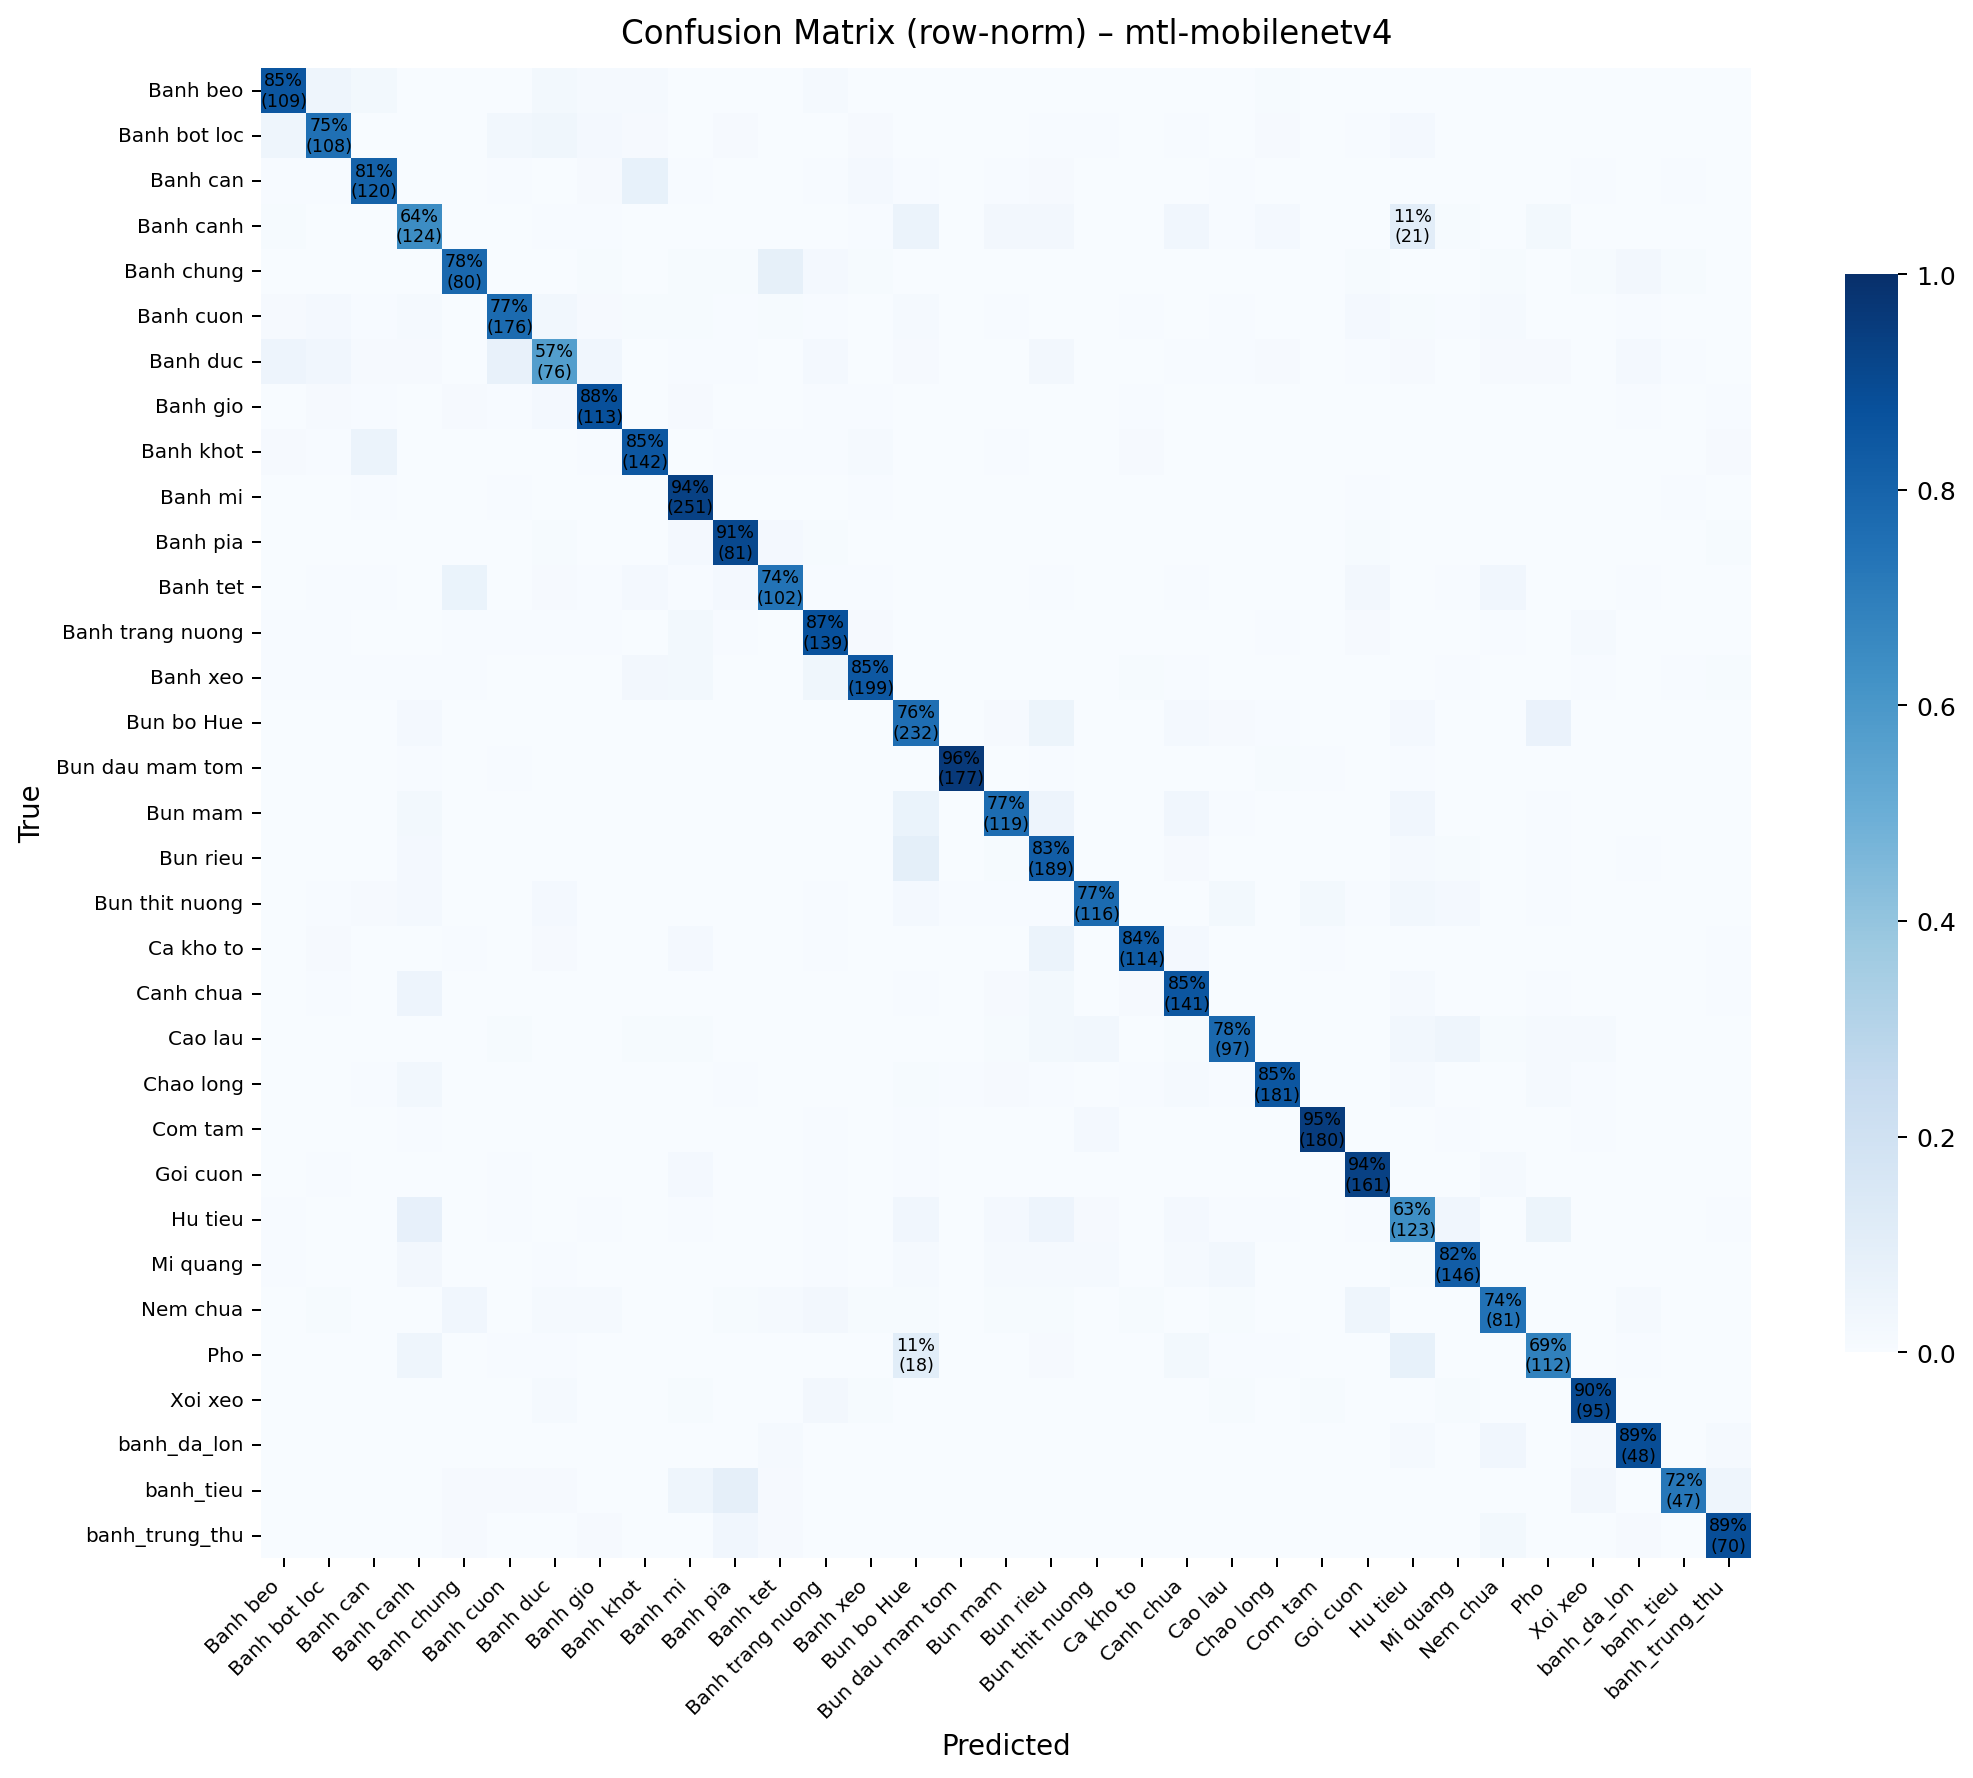

✓ Saved: ./images\mtl-mobilenetv4_cm.png


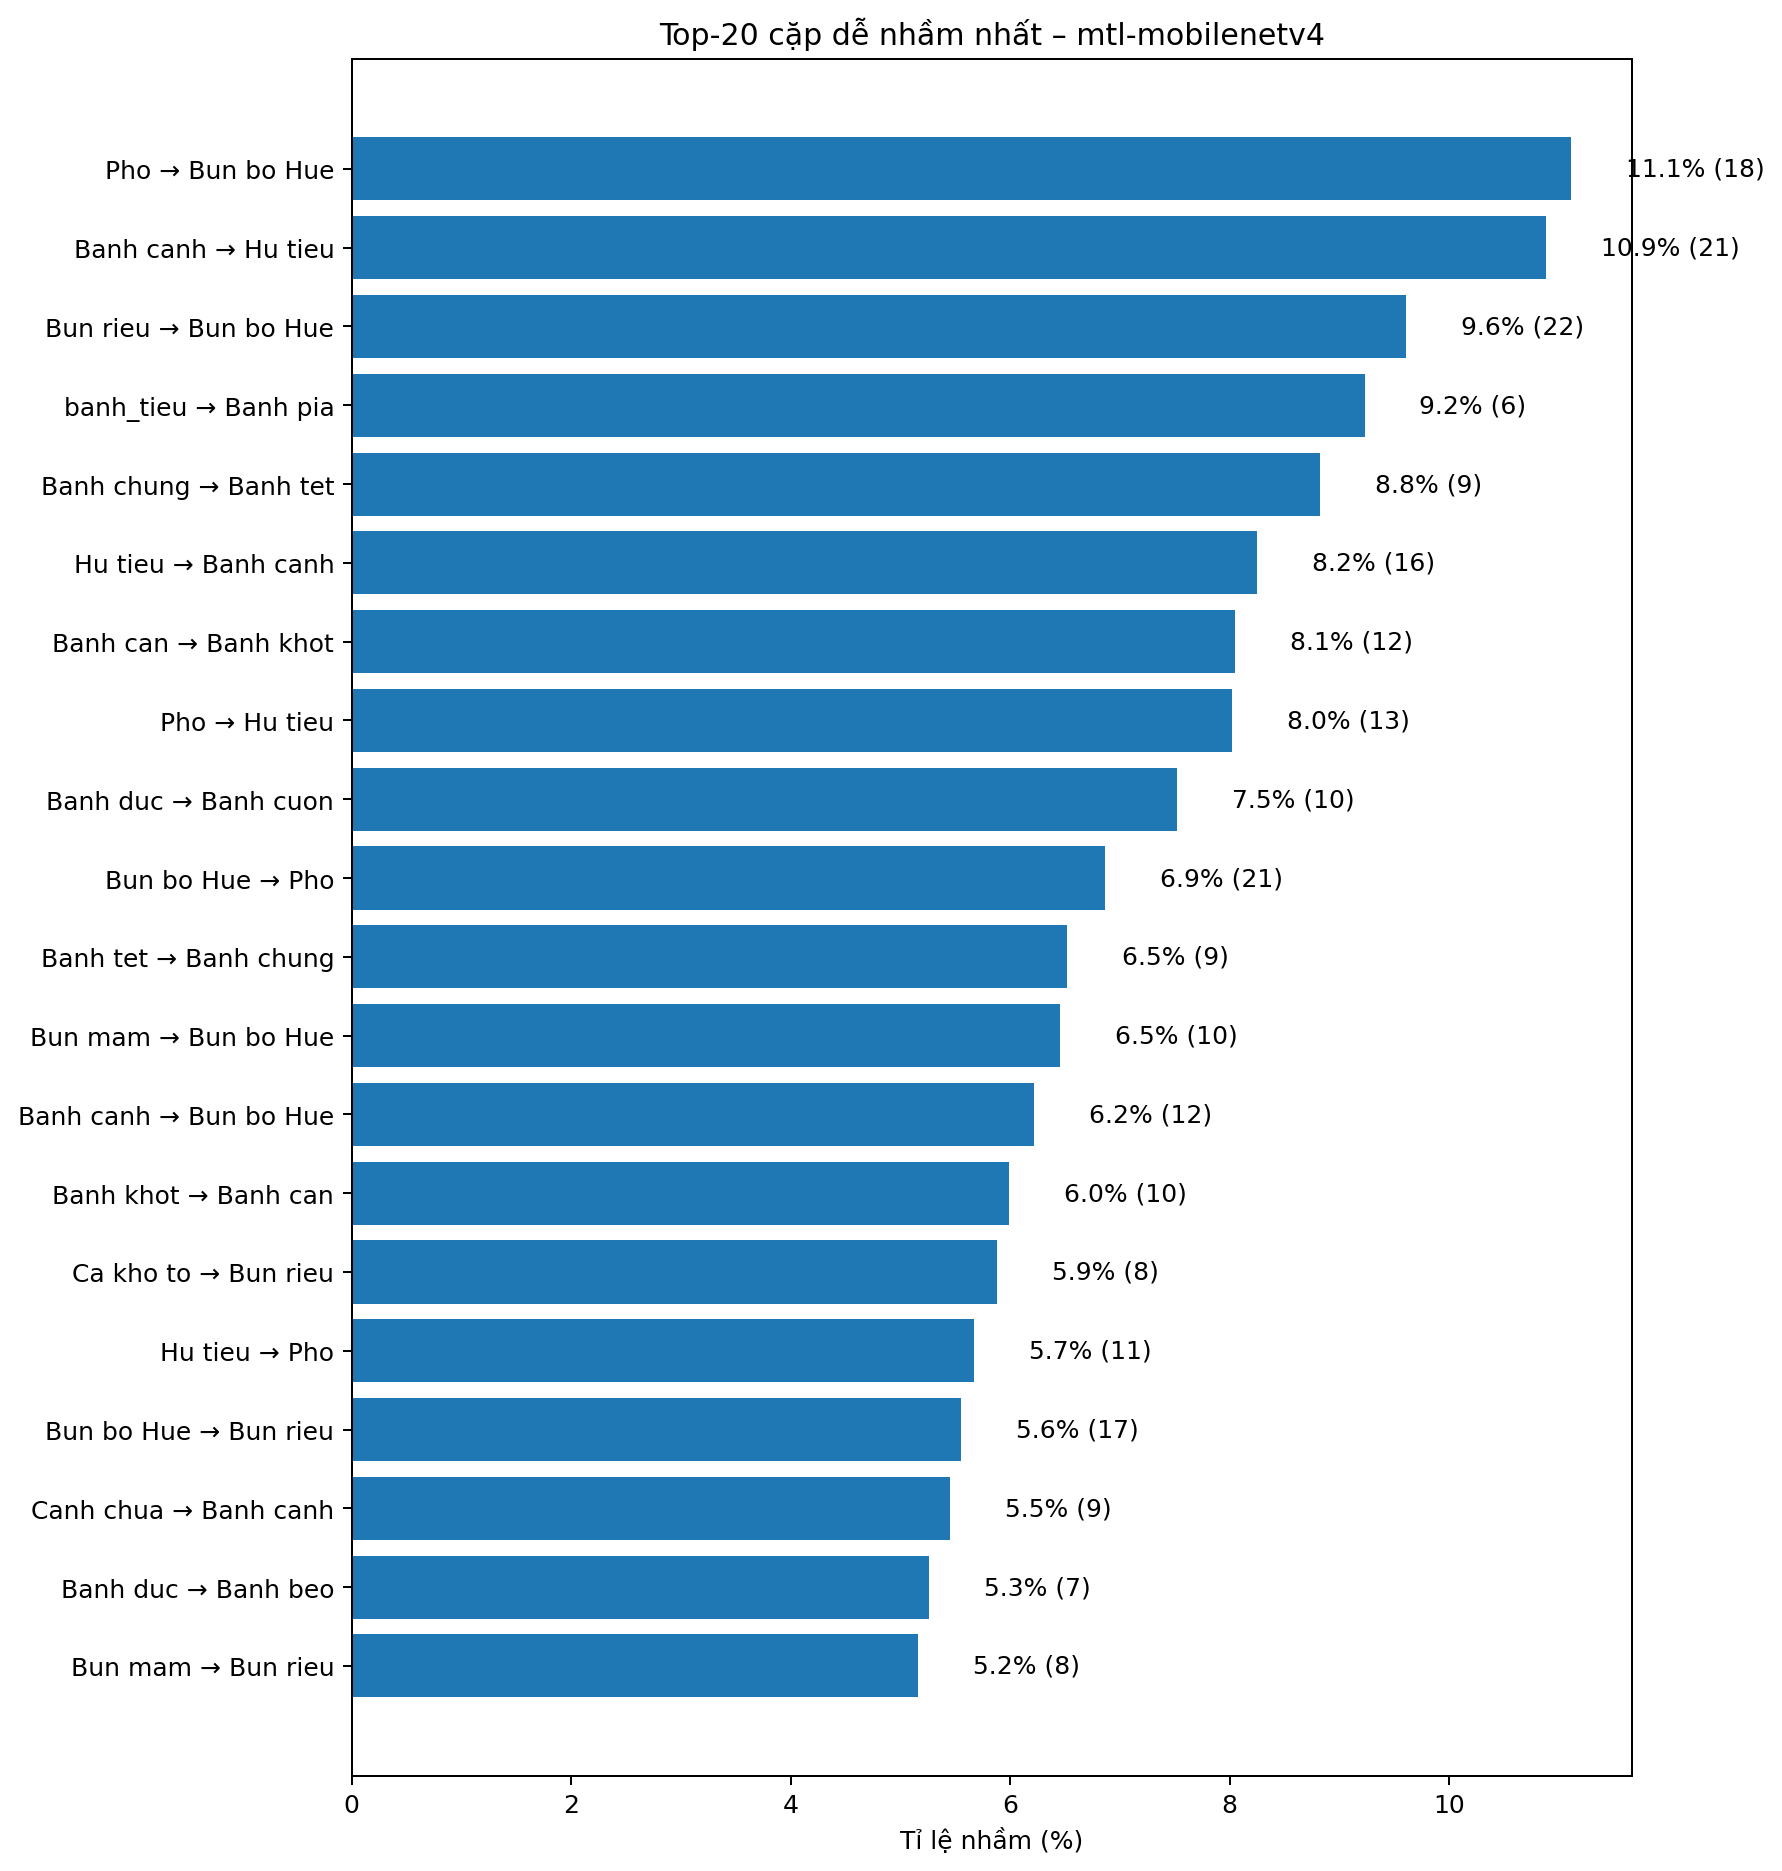

✓ Saved: ./images\mtl-mobilenetv4_top20_confused.png


,run,acc,precision,recall,f1,img_size,batch_size
0,mtl-mobilenetv4,0.812584,0.815148,0.812428,0.812238,224,64


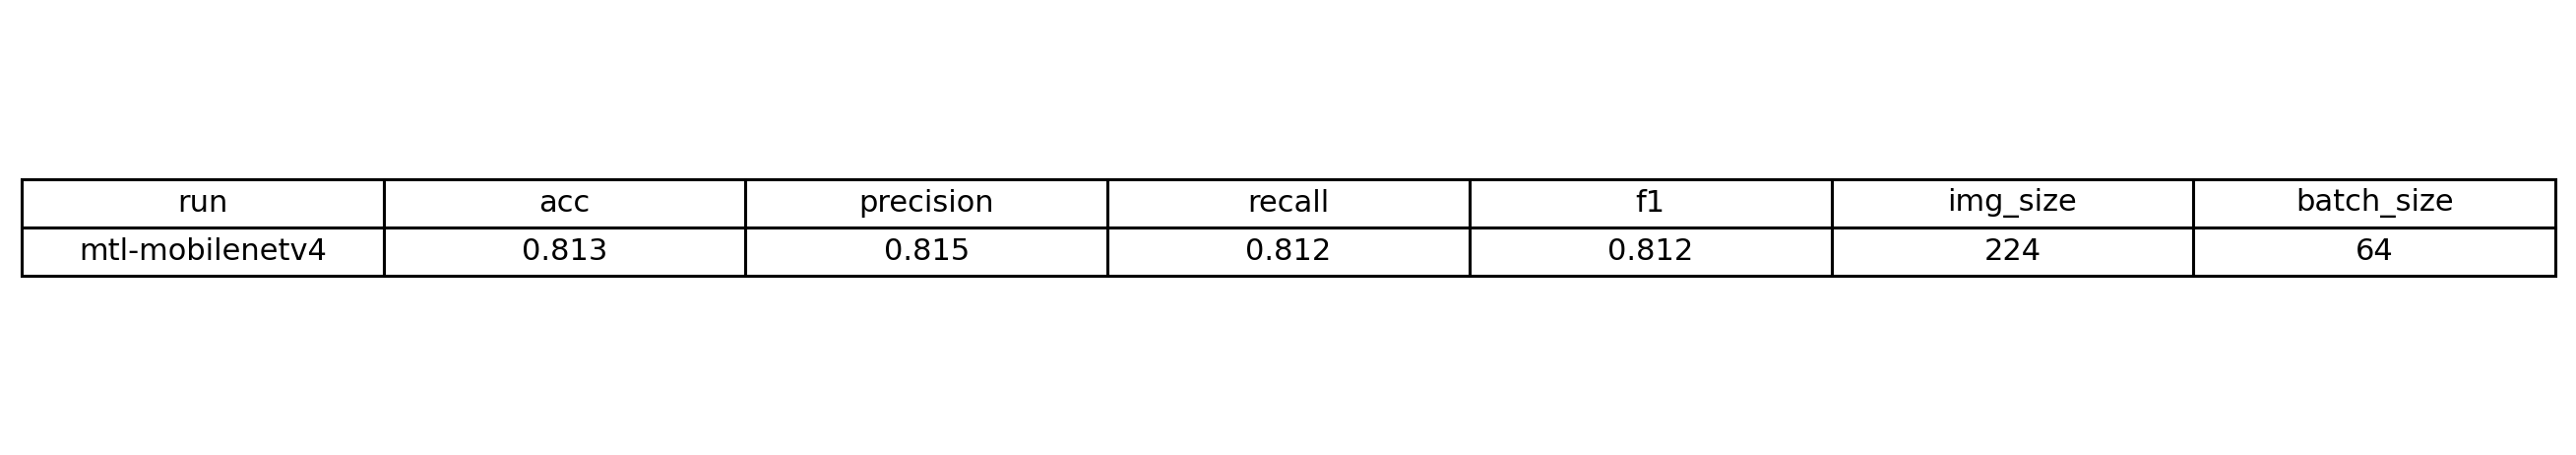

✓ Saved: ./images\summary_models.png


In [114]:
# === CELL 102: Đánh giá một mô hình cụ thể (thư mục có checkpoints/ ===
evaluate_entry(os.path.join(RUNS_DIR, "mtl-mobilenetv4"), topk_pairs=20, min_count=3)

Đánh giá: miniCNN
[load] missing keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.3.0.weight', 'features.3.1.weight', 'features.3.1.bias', 'features.3.1.running_mean', 'features.3.1.running_var', 'features.3.3.weight', 'features.3.4.weight', 'features.3.4.bias', 'features.3.4.running_mean', 'features.3.4.running_var', 'features.4.0.weight', 'features.4.1.weight', 'features.4.1.bias', 'features.4.1.running_mean', 'features.4.1.running_var', 'features.4.3.weight', 'features.4.4.weight', 'features.4.4.bias', 'features.4.4.running_mean', 'features.4.4.running_var', 'features.5.0.weight', 'features.5.1.weight', 'features.5.1.bias', 'features.5.1.running_mean', 'features.5.1.running_var', 'features.5.3.weight', 'features.5.4.weight', 'features.5.4.bias', 'features.5.4.running_mean', 'features.5.4.running_var', 'features.6.0.weight', 'features.6.1.weight', 'features.6.1.bias', 'features.6.1.running_mean', 'featu

C:\Users\Admin\AppData\Local\Temp\ipykernel_24036\1584217865.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


{'ms_per_img': 4.0374040603637695, 'FPS': 247.68390407520923, 'params': 3240801, 'state_size_mb': 12.44637680053711}
Không có run hợp lệ trong thư mục: ./Runs


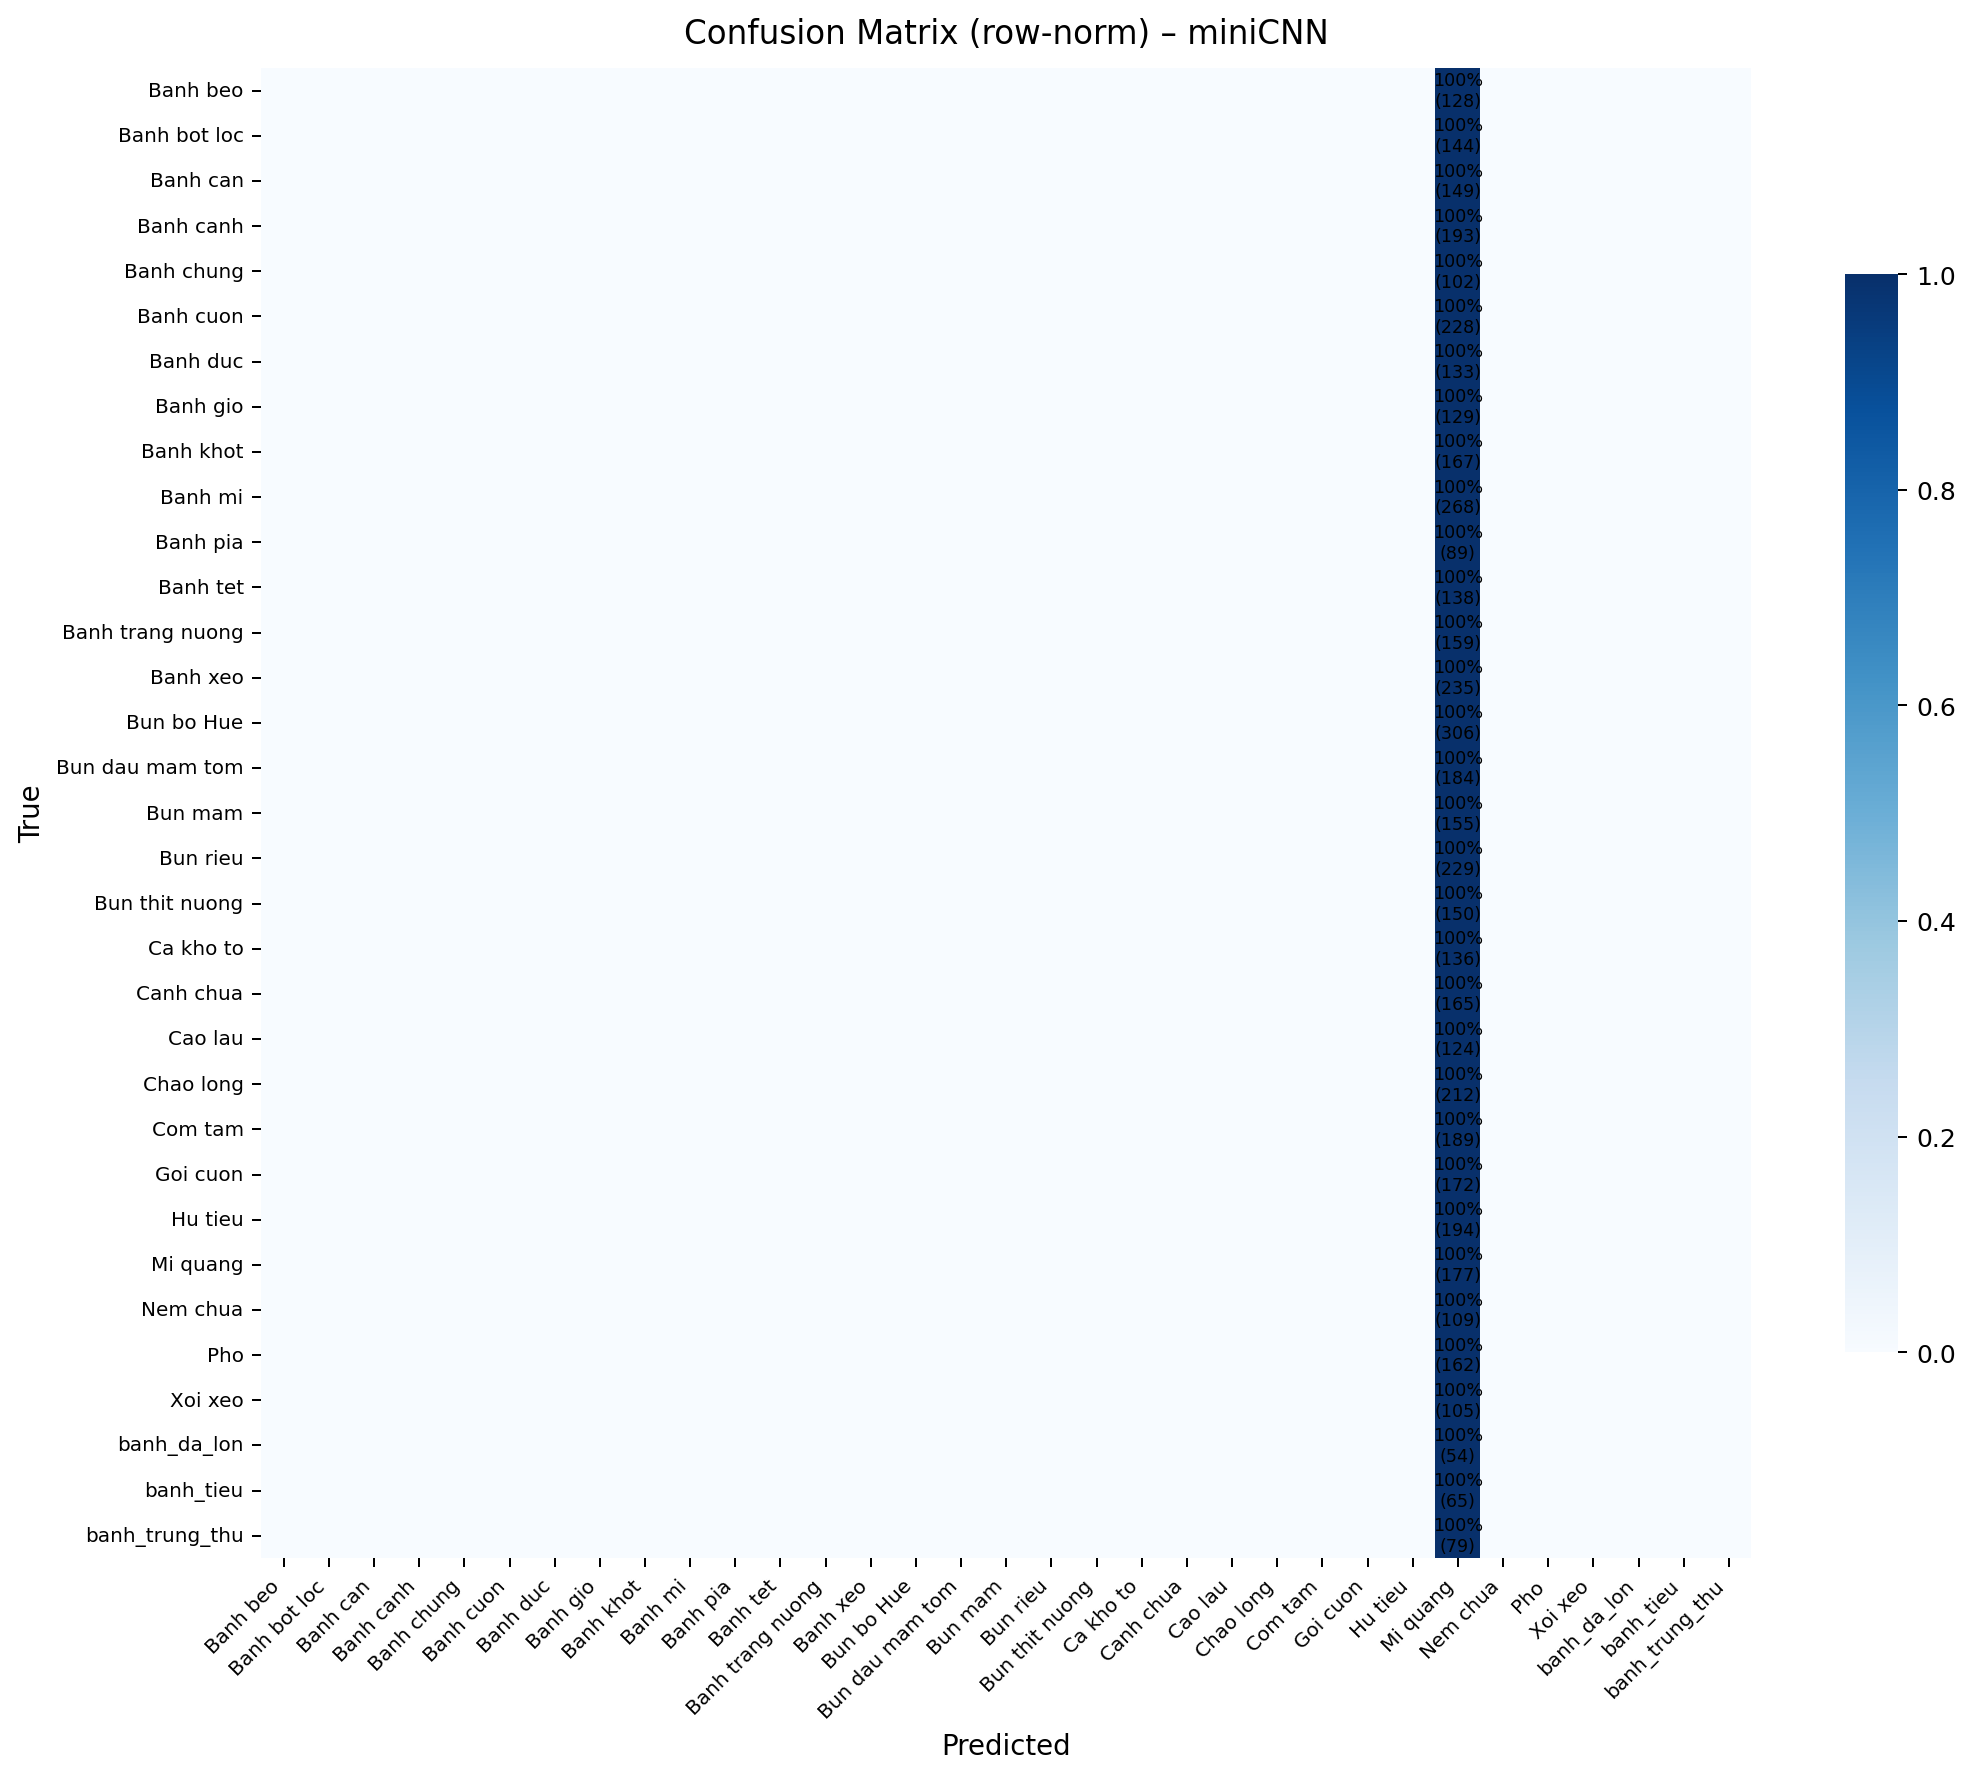

✓ Saved: ./images\miniCNN_cm.png


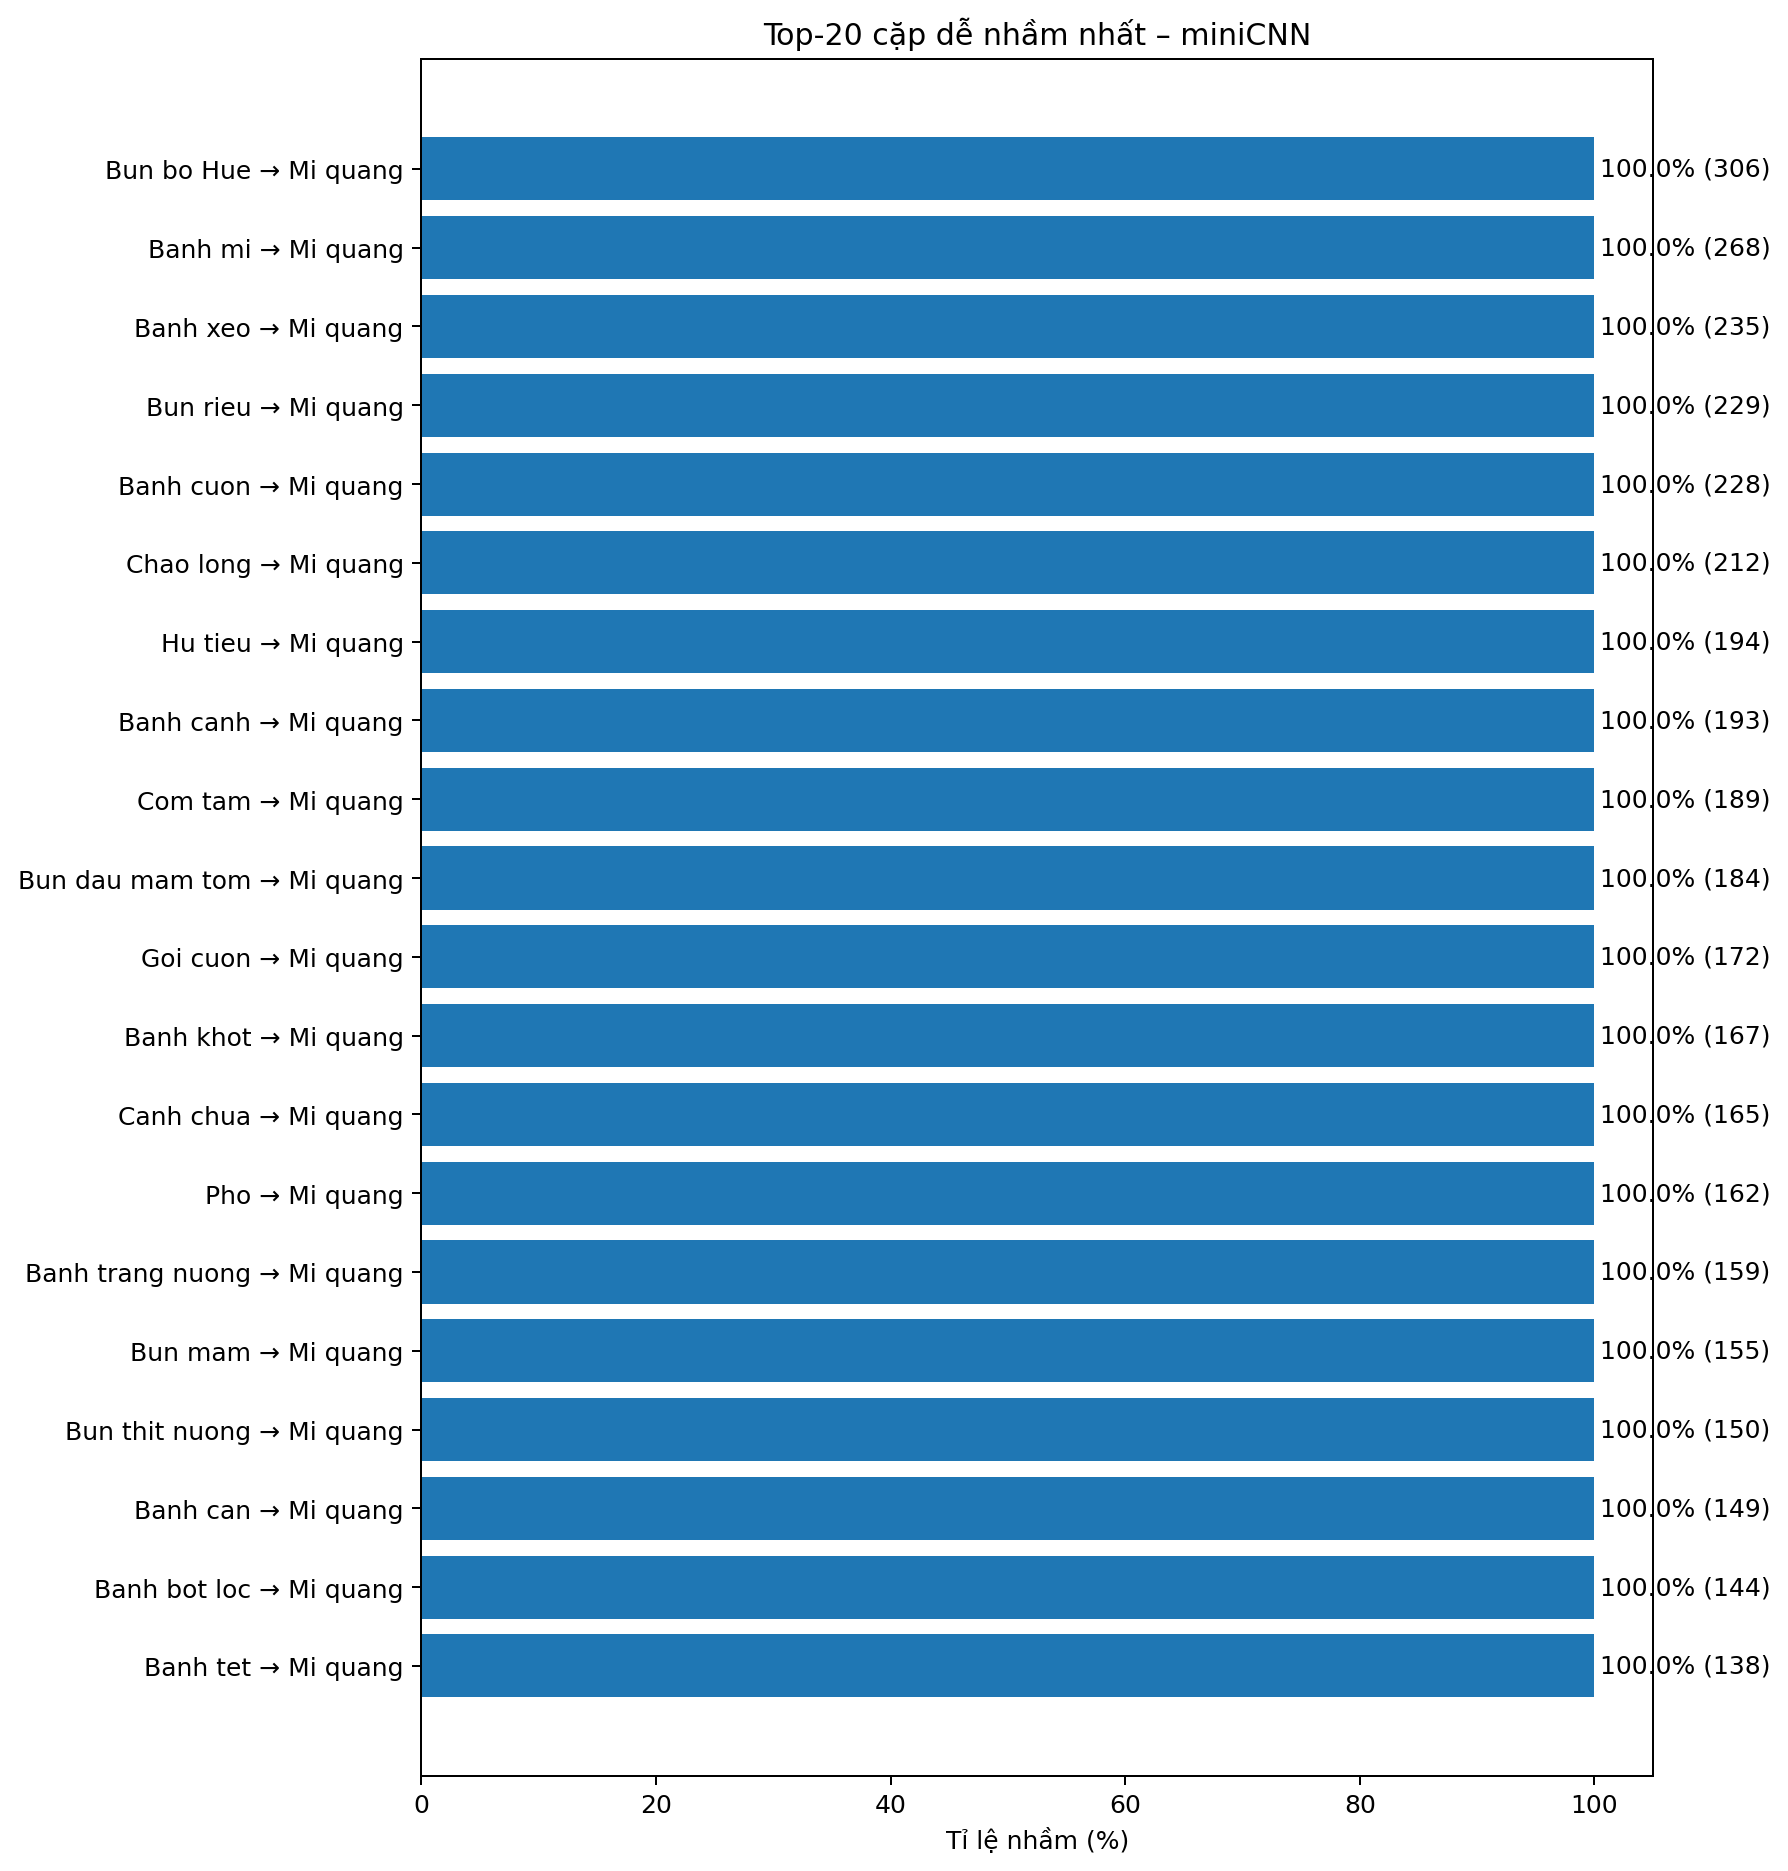

✓ Saved: ./images\miniCNN_top20_confused.png
Đánh giá: mtl-cnn


C:\Users\Admin\AppData\Local\Temp\ipykernel_24036\1584217865.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


{'ms_per_img': 3.546895980834961, 'FPS': 281.9366582508557, 'params': 3240801, 'state_size_mb': 12.44637680053711}
Không có run hợp lệ trong thư mục: ./Runs


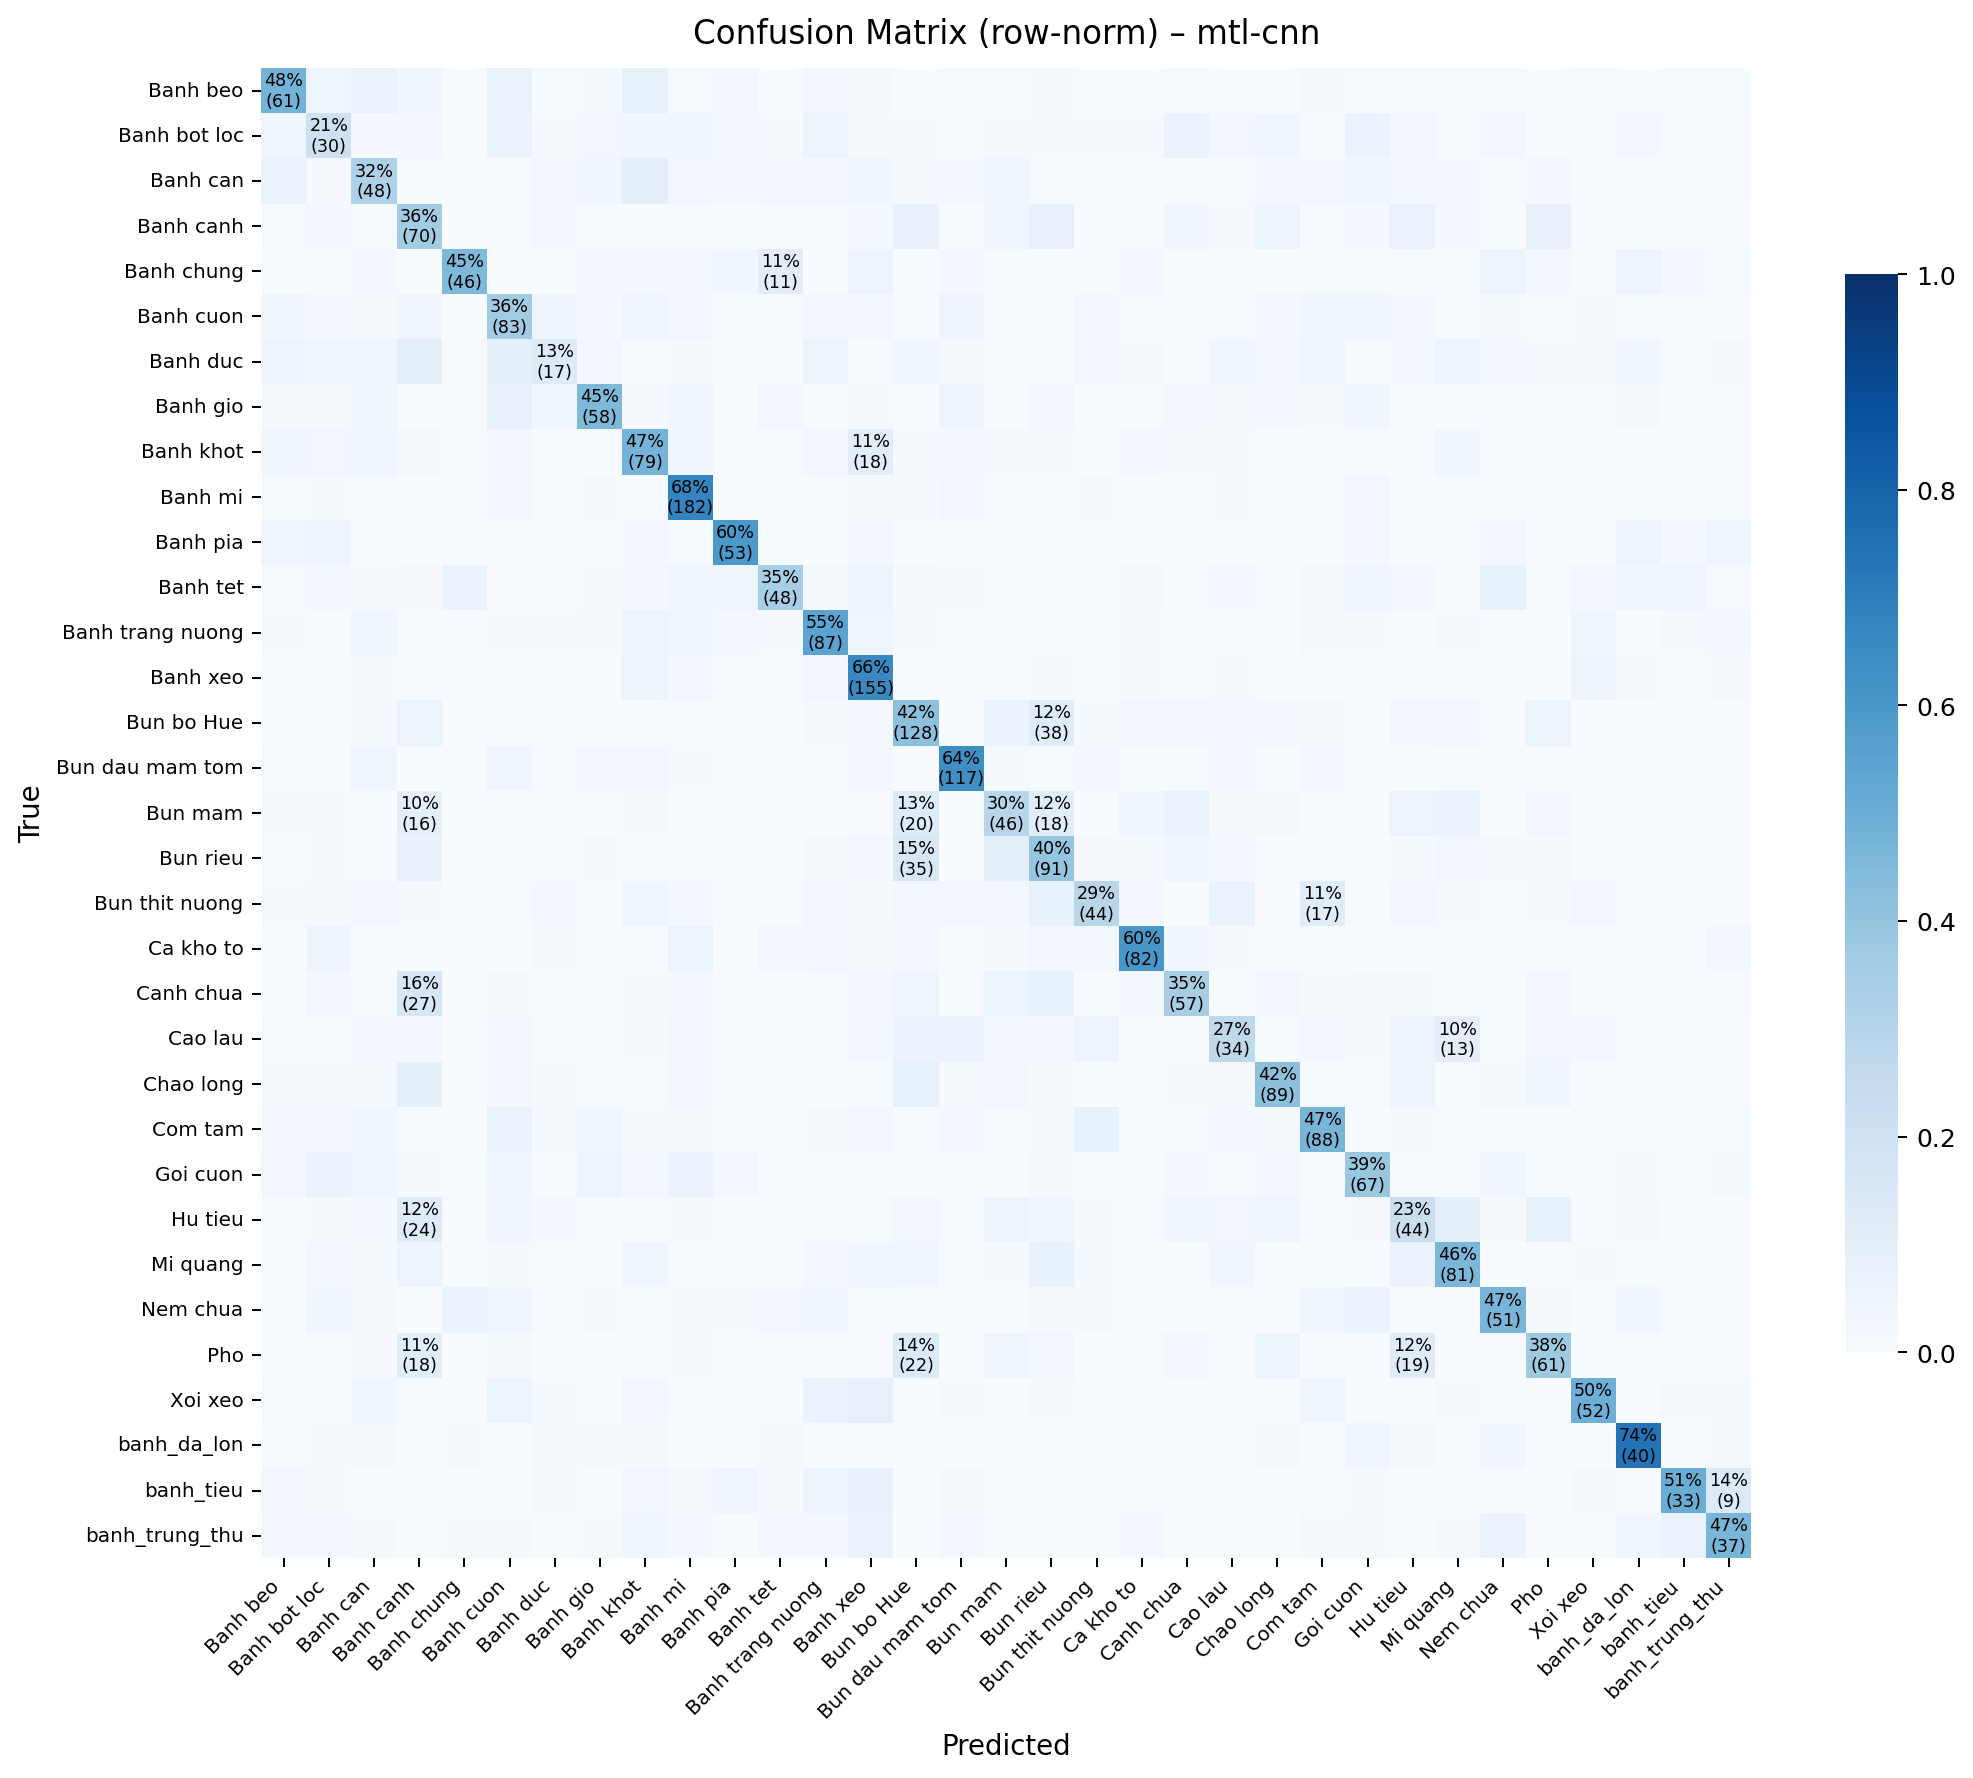

✓ Saved: ./images\mtl-cnn_cm.png


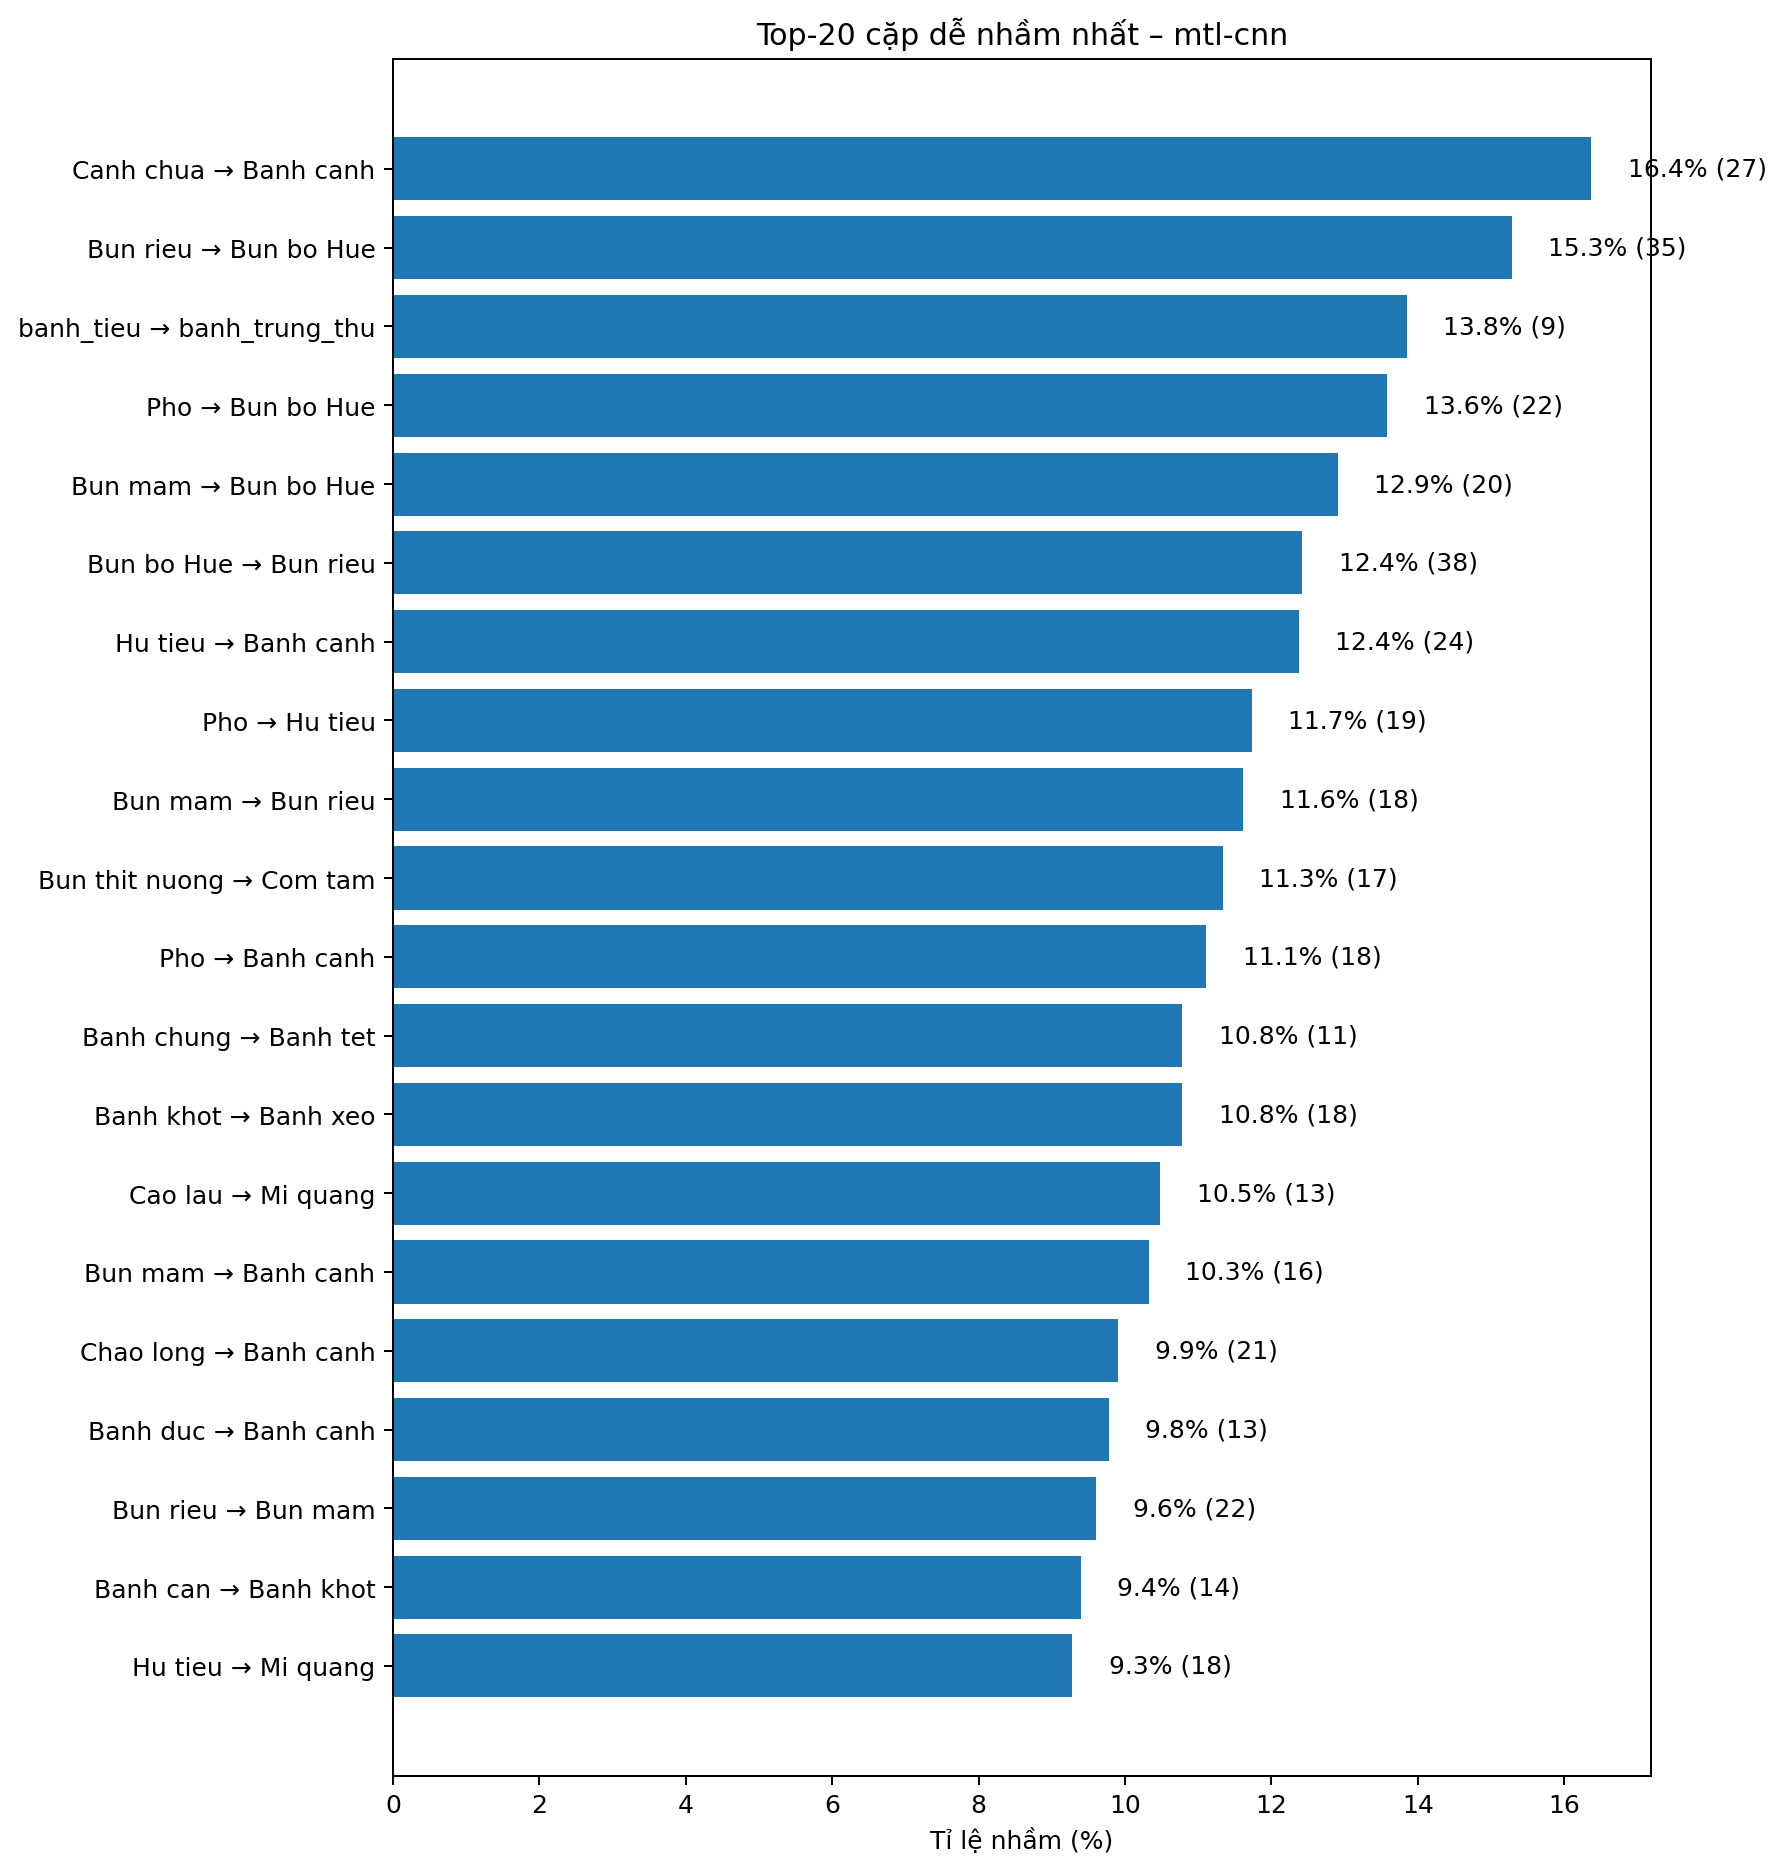

✓ Saved: ./images\mtl-cnn_top20_confused.png
Đánh giá: mtl-efficientnet_b0


C:\Users\Admin\AppData\Local\Temp\ipykernel_24036\1584217865.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


{'ms_per_img': 11.346397399902344, 'FPS': 88.13370136397715, 'params': 4049821, 'state_size_mb': 15.609493255615234}
Không có run hợp lệ trong thư mục: ./Runs


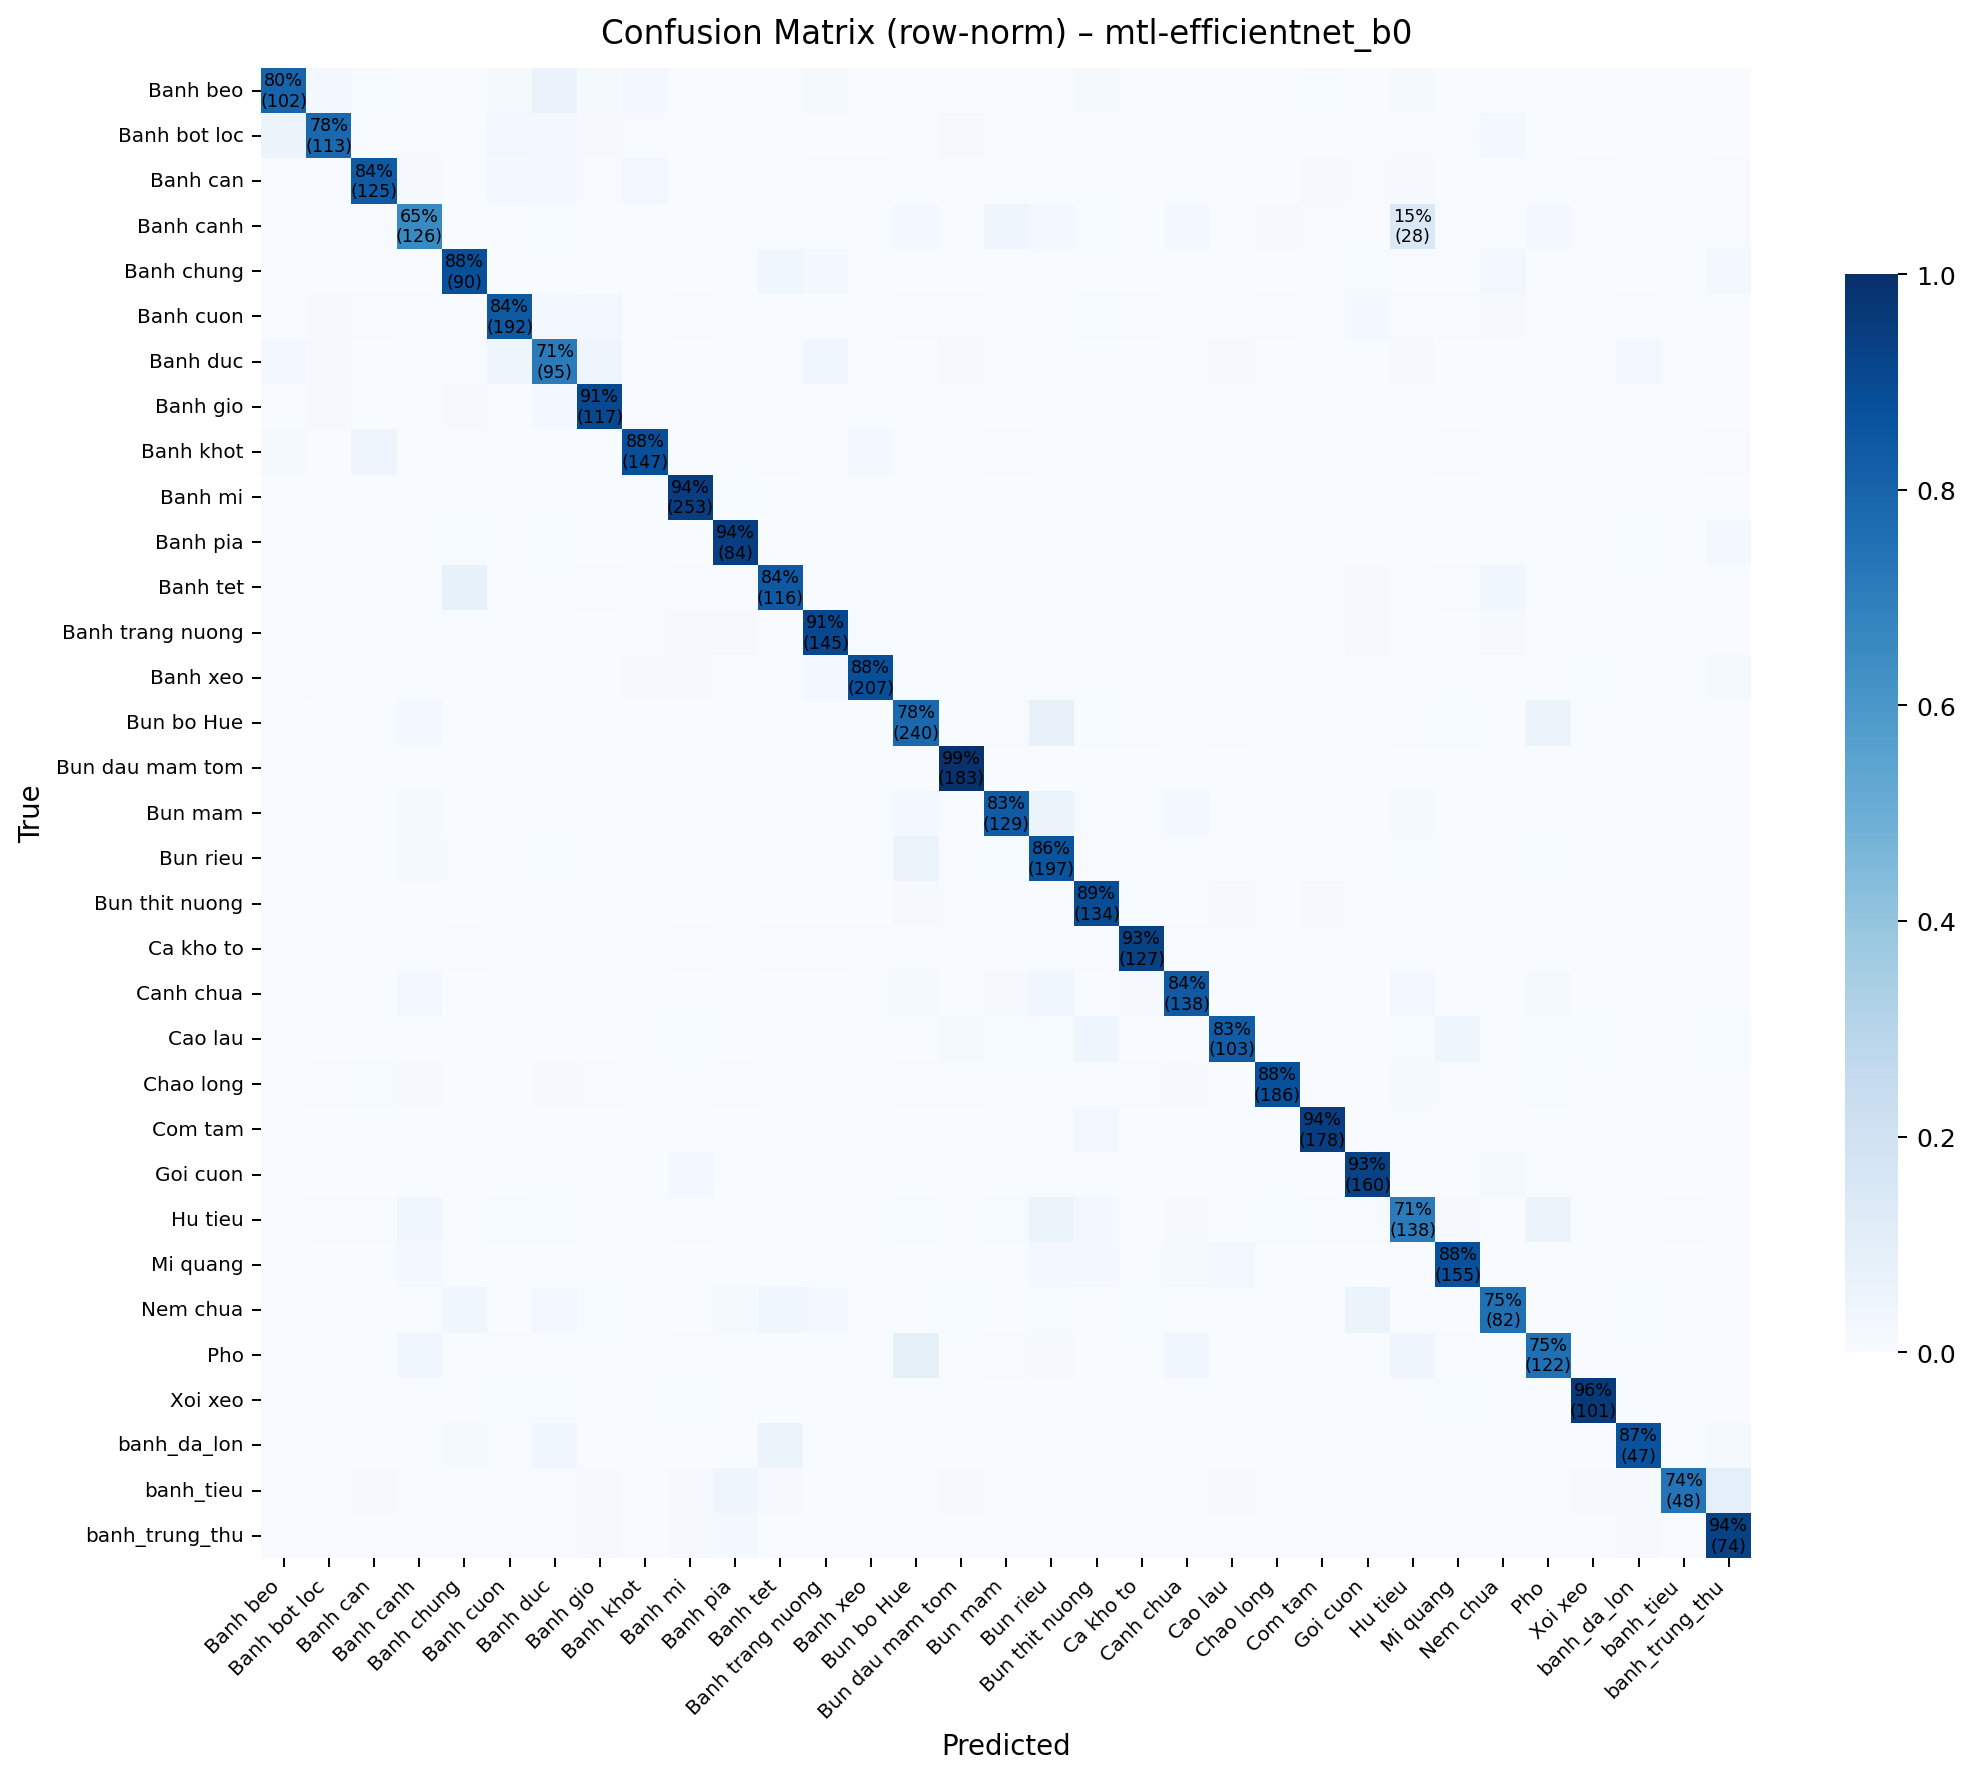

✓ Saved: ./images\mtl-efficientnet_b0_cm.png


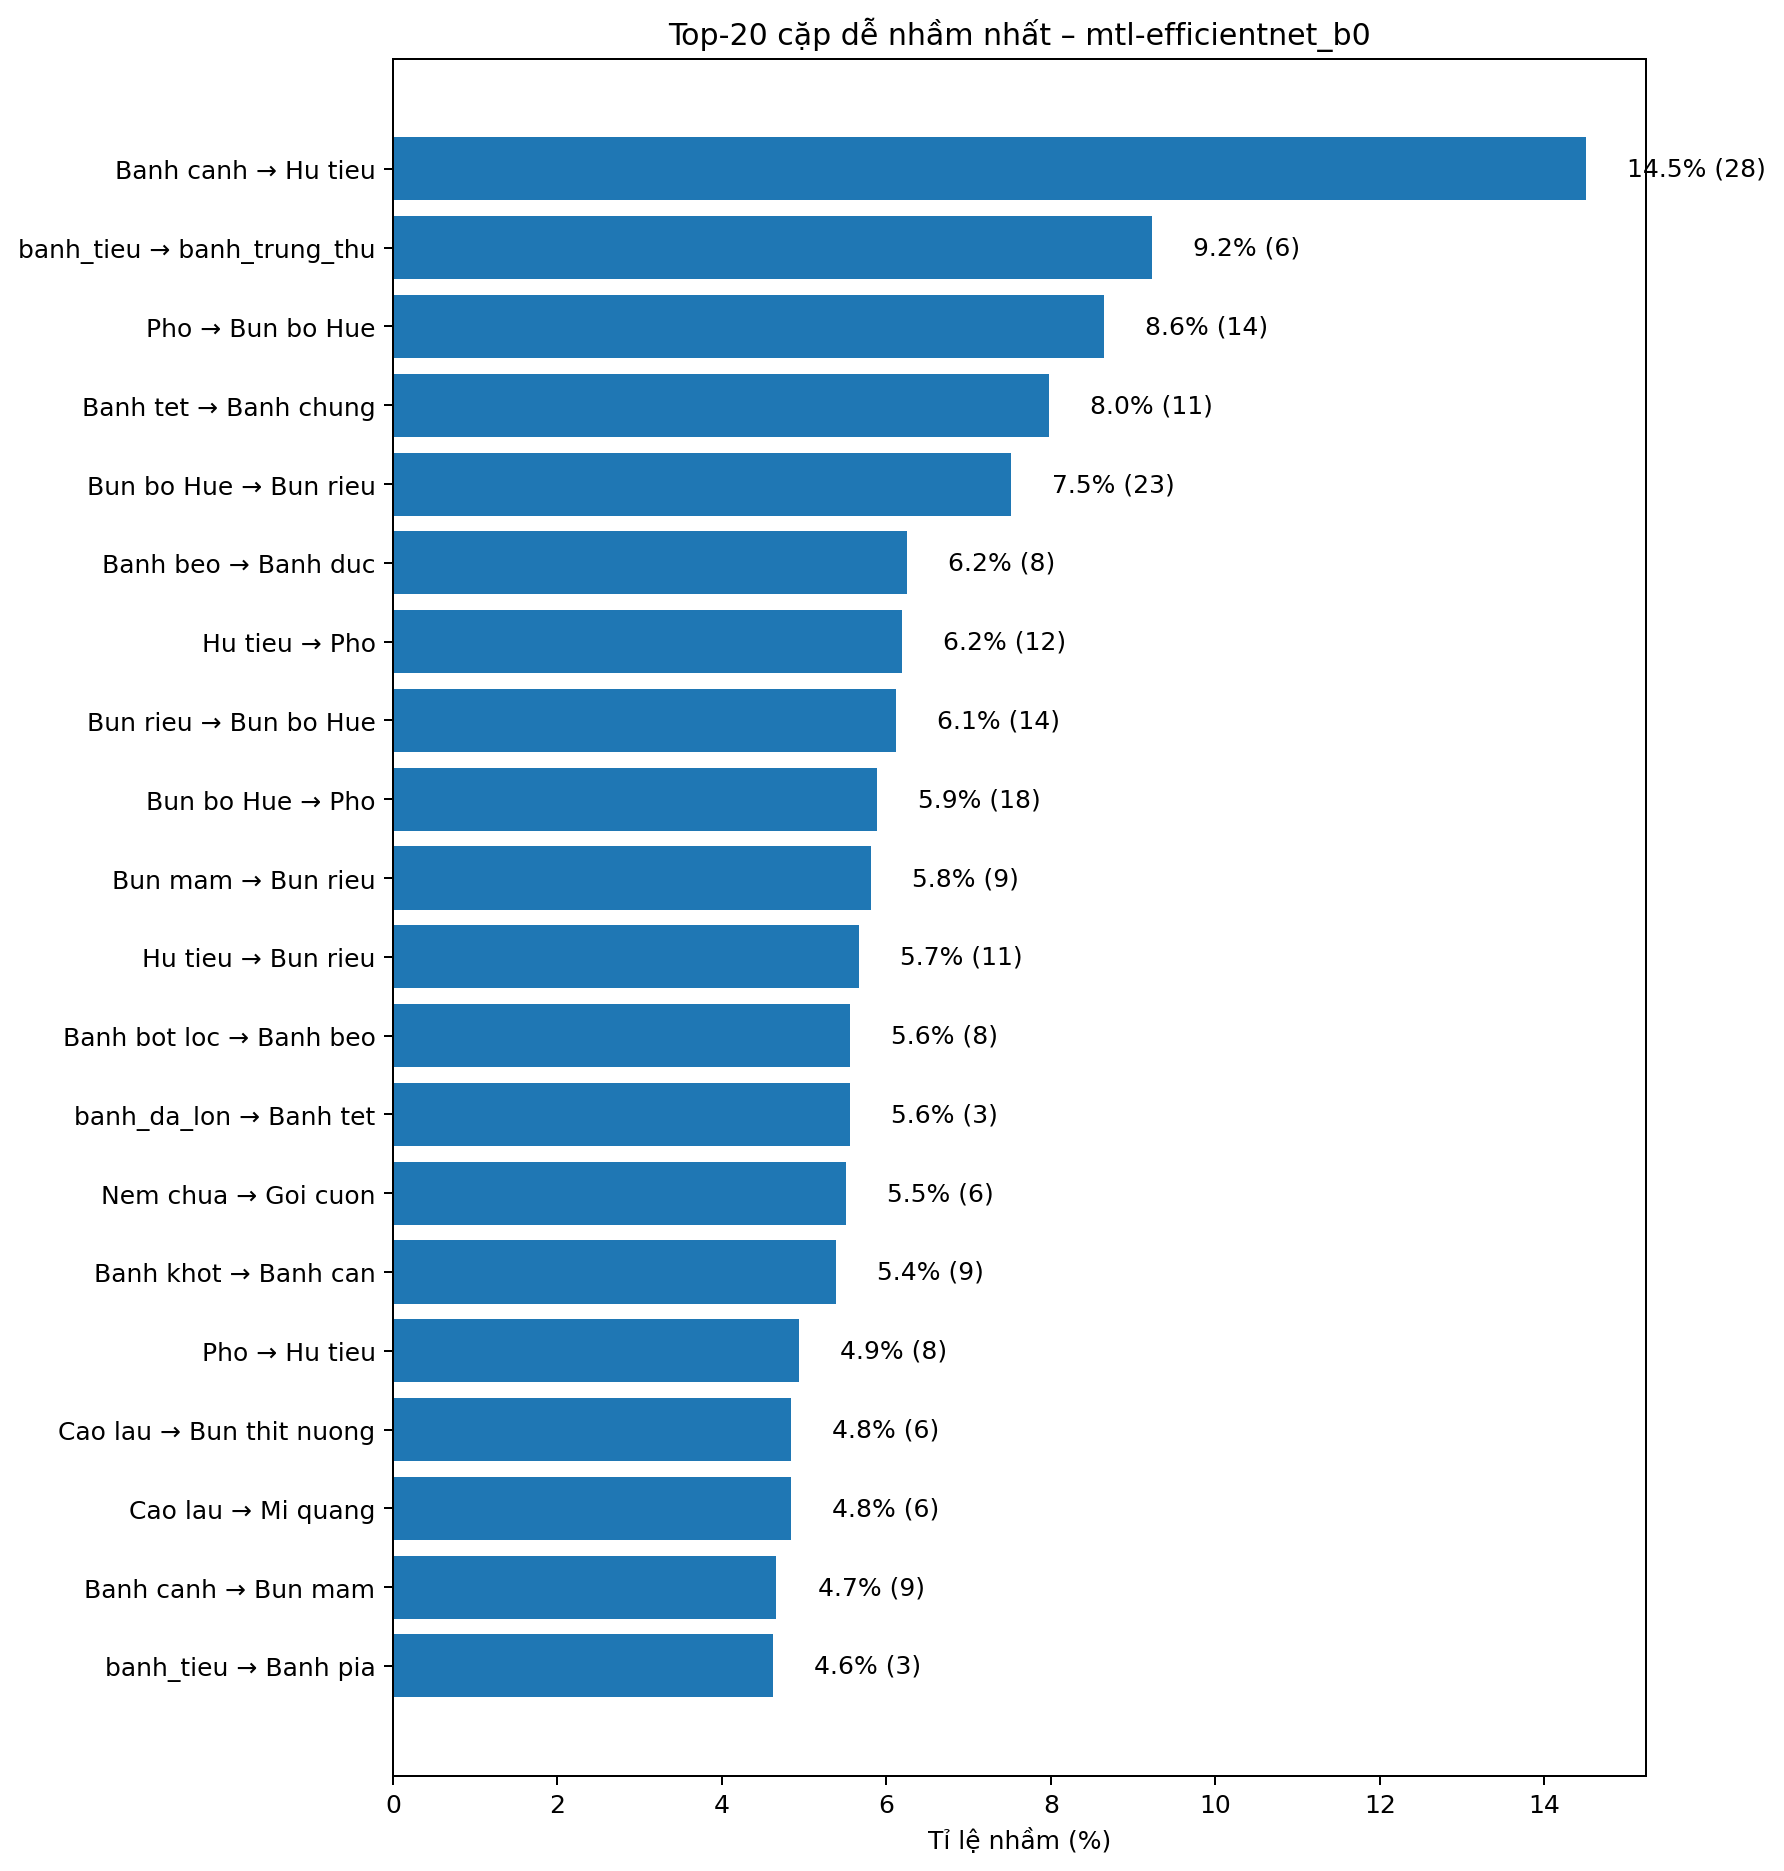

✓ Saved: ./images\mtl-efficientnet_b0_top20_confused.png
Đánh giá: mtl-mobilenetv4


C:\Users\Admin\AppData\Local\Temp\ipykernel_24036\1584217865.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


{'ms_per_img': 7.270722389221191, 'FPS': 137.53791528094854, 'params': 2535297, 'state_size_mb': 9.767444610595703}
Không có run hợp lệ trong thư mục: ./Runs


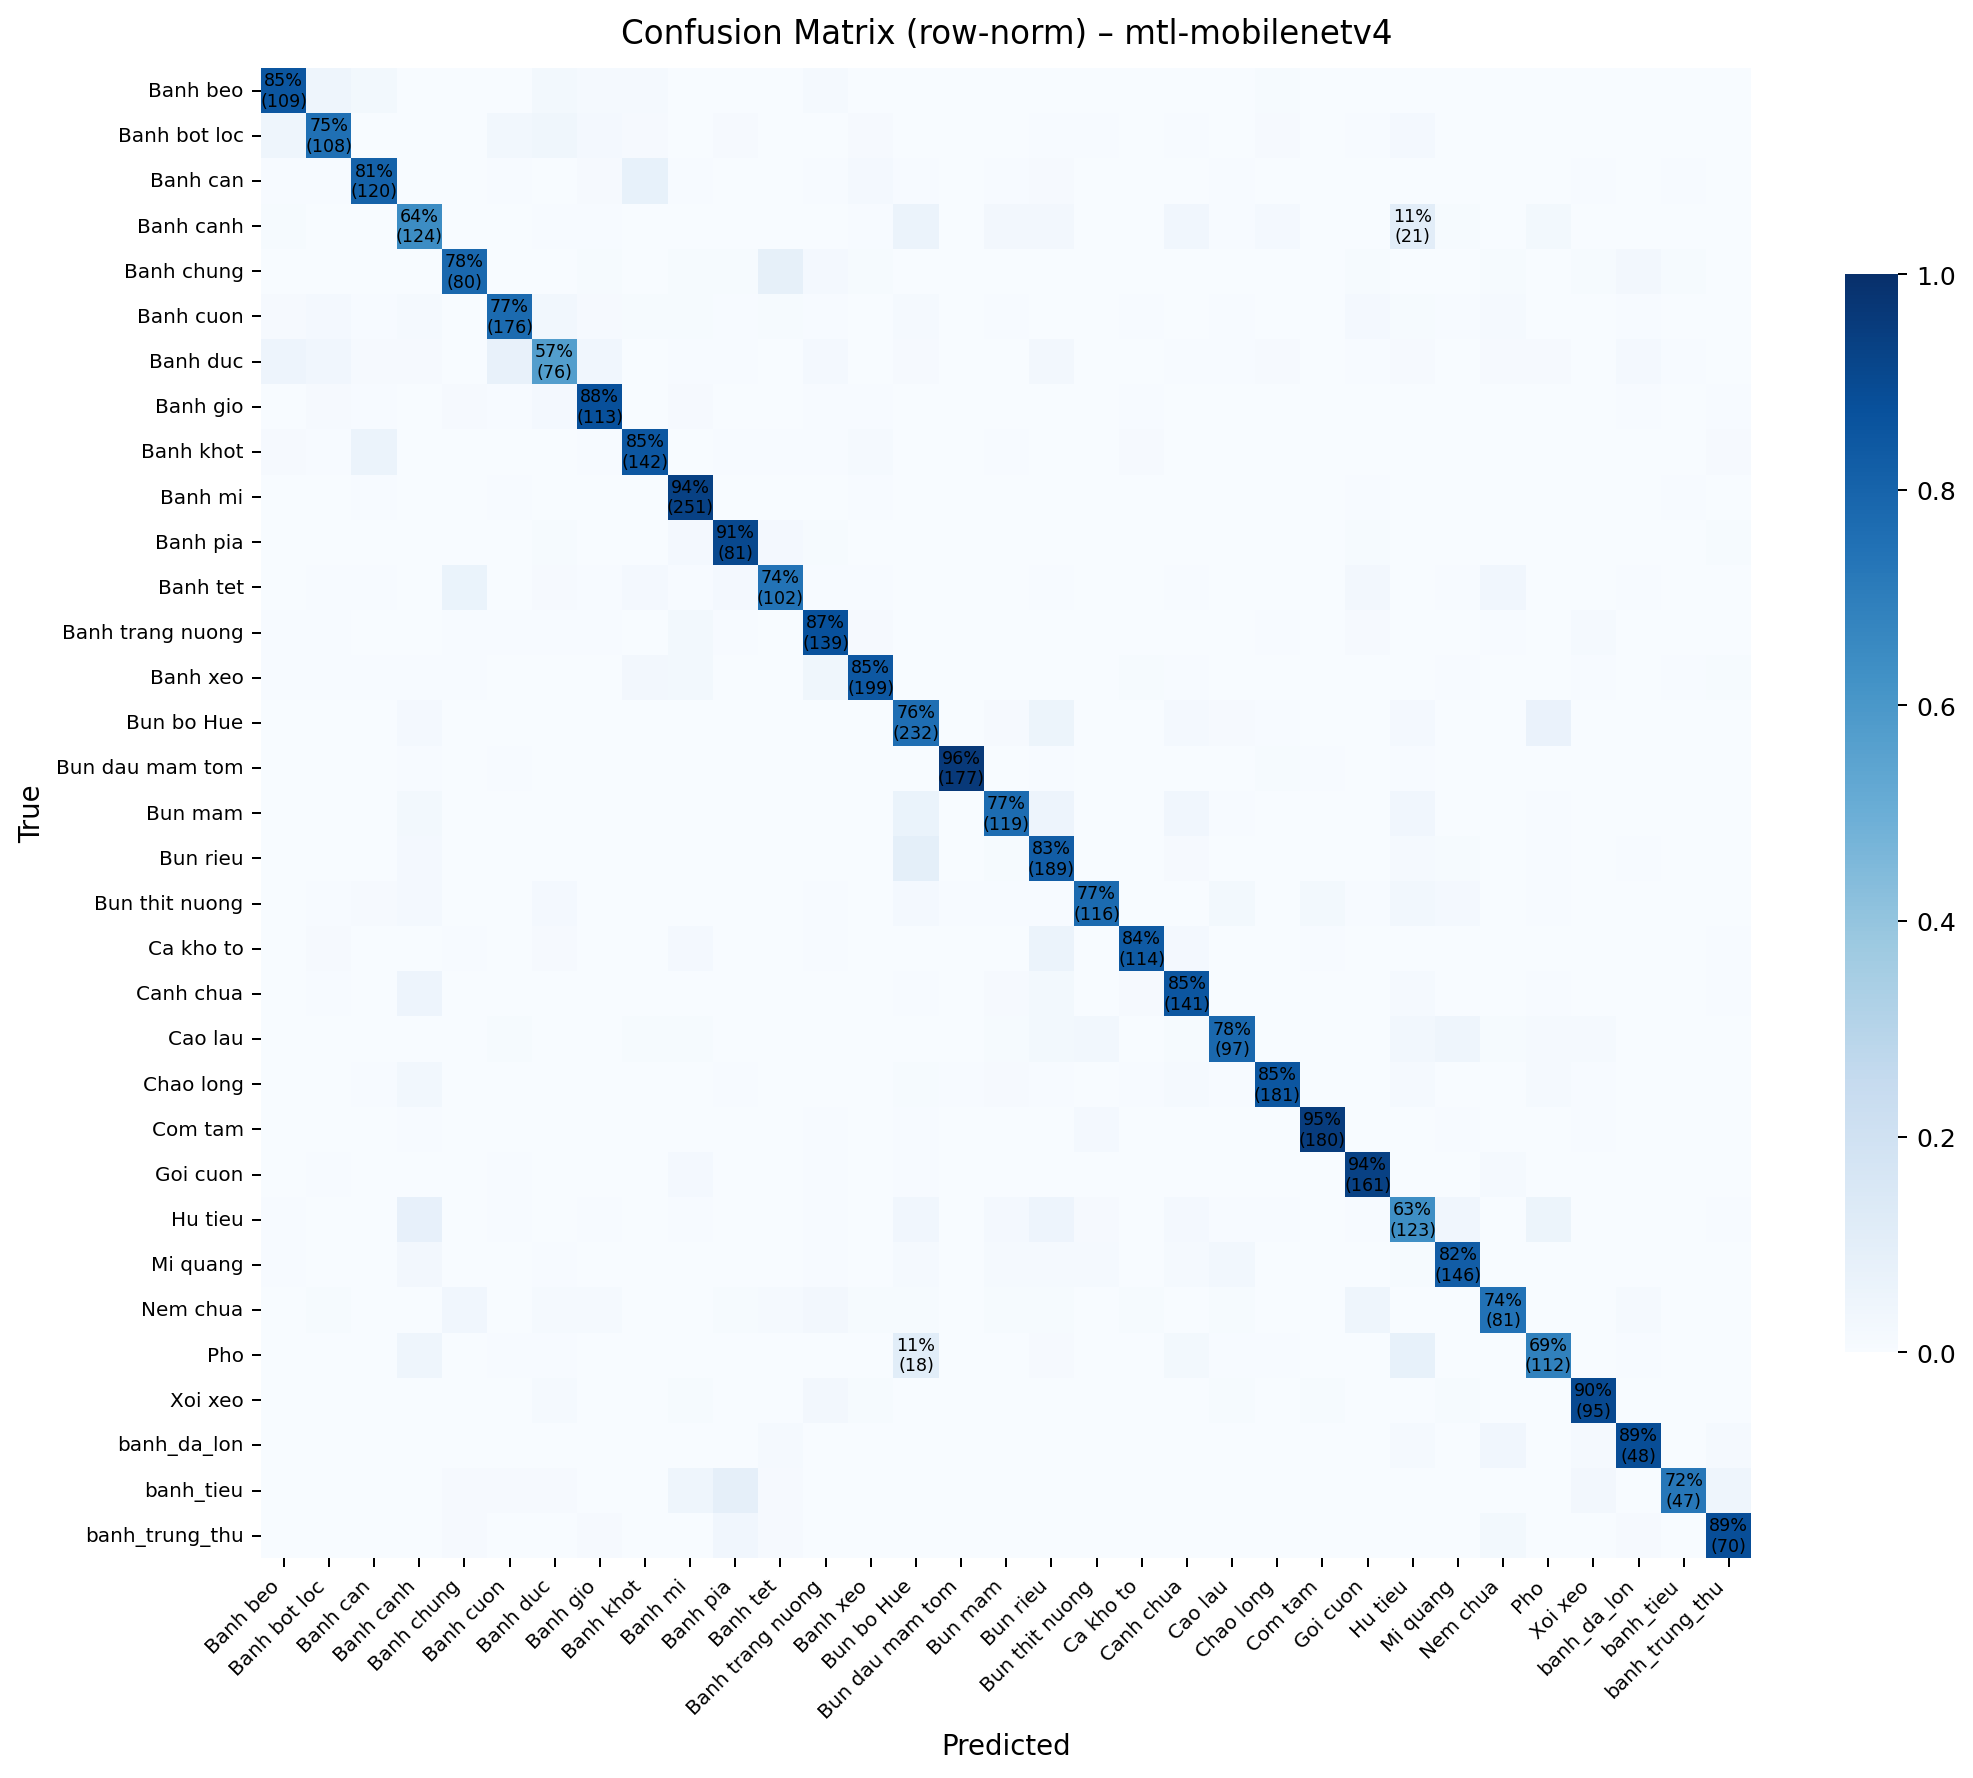

✓ Saved: ./images\mtl-mobilenetv4_cm.png


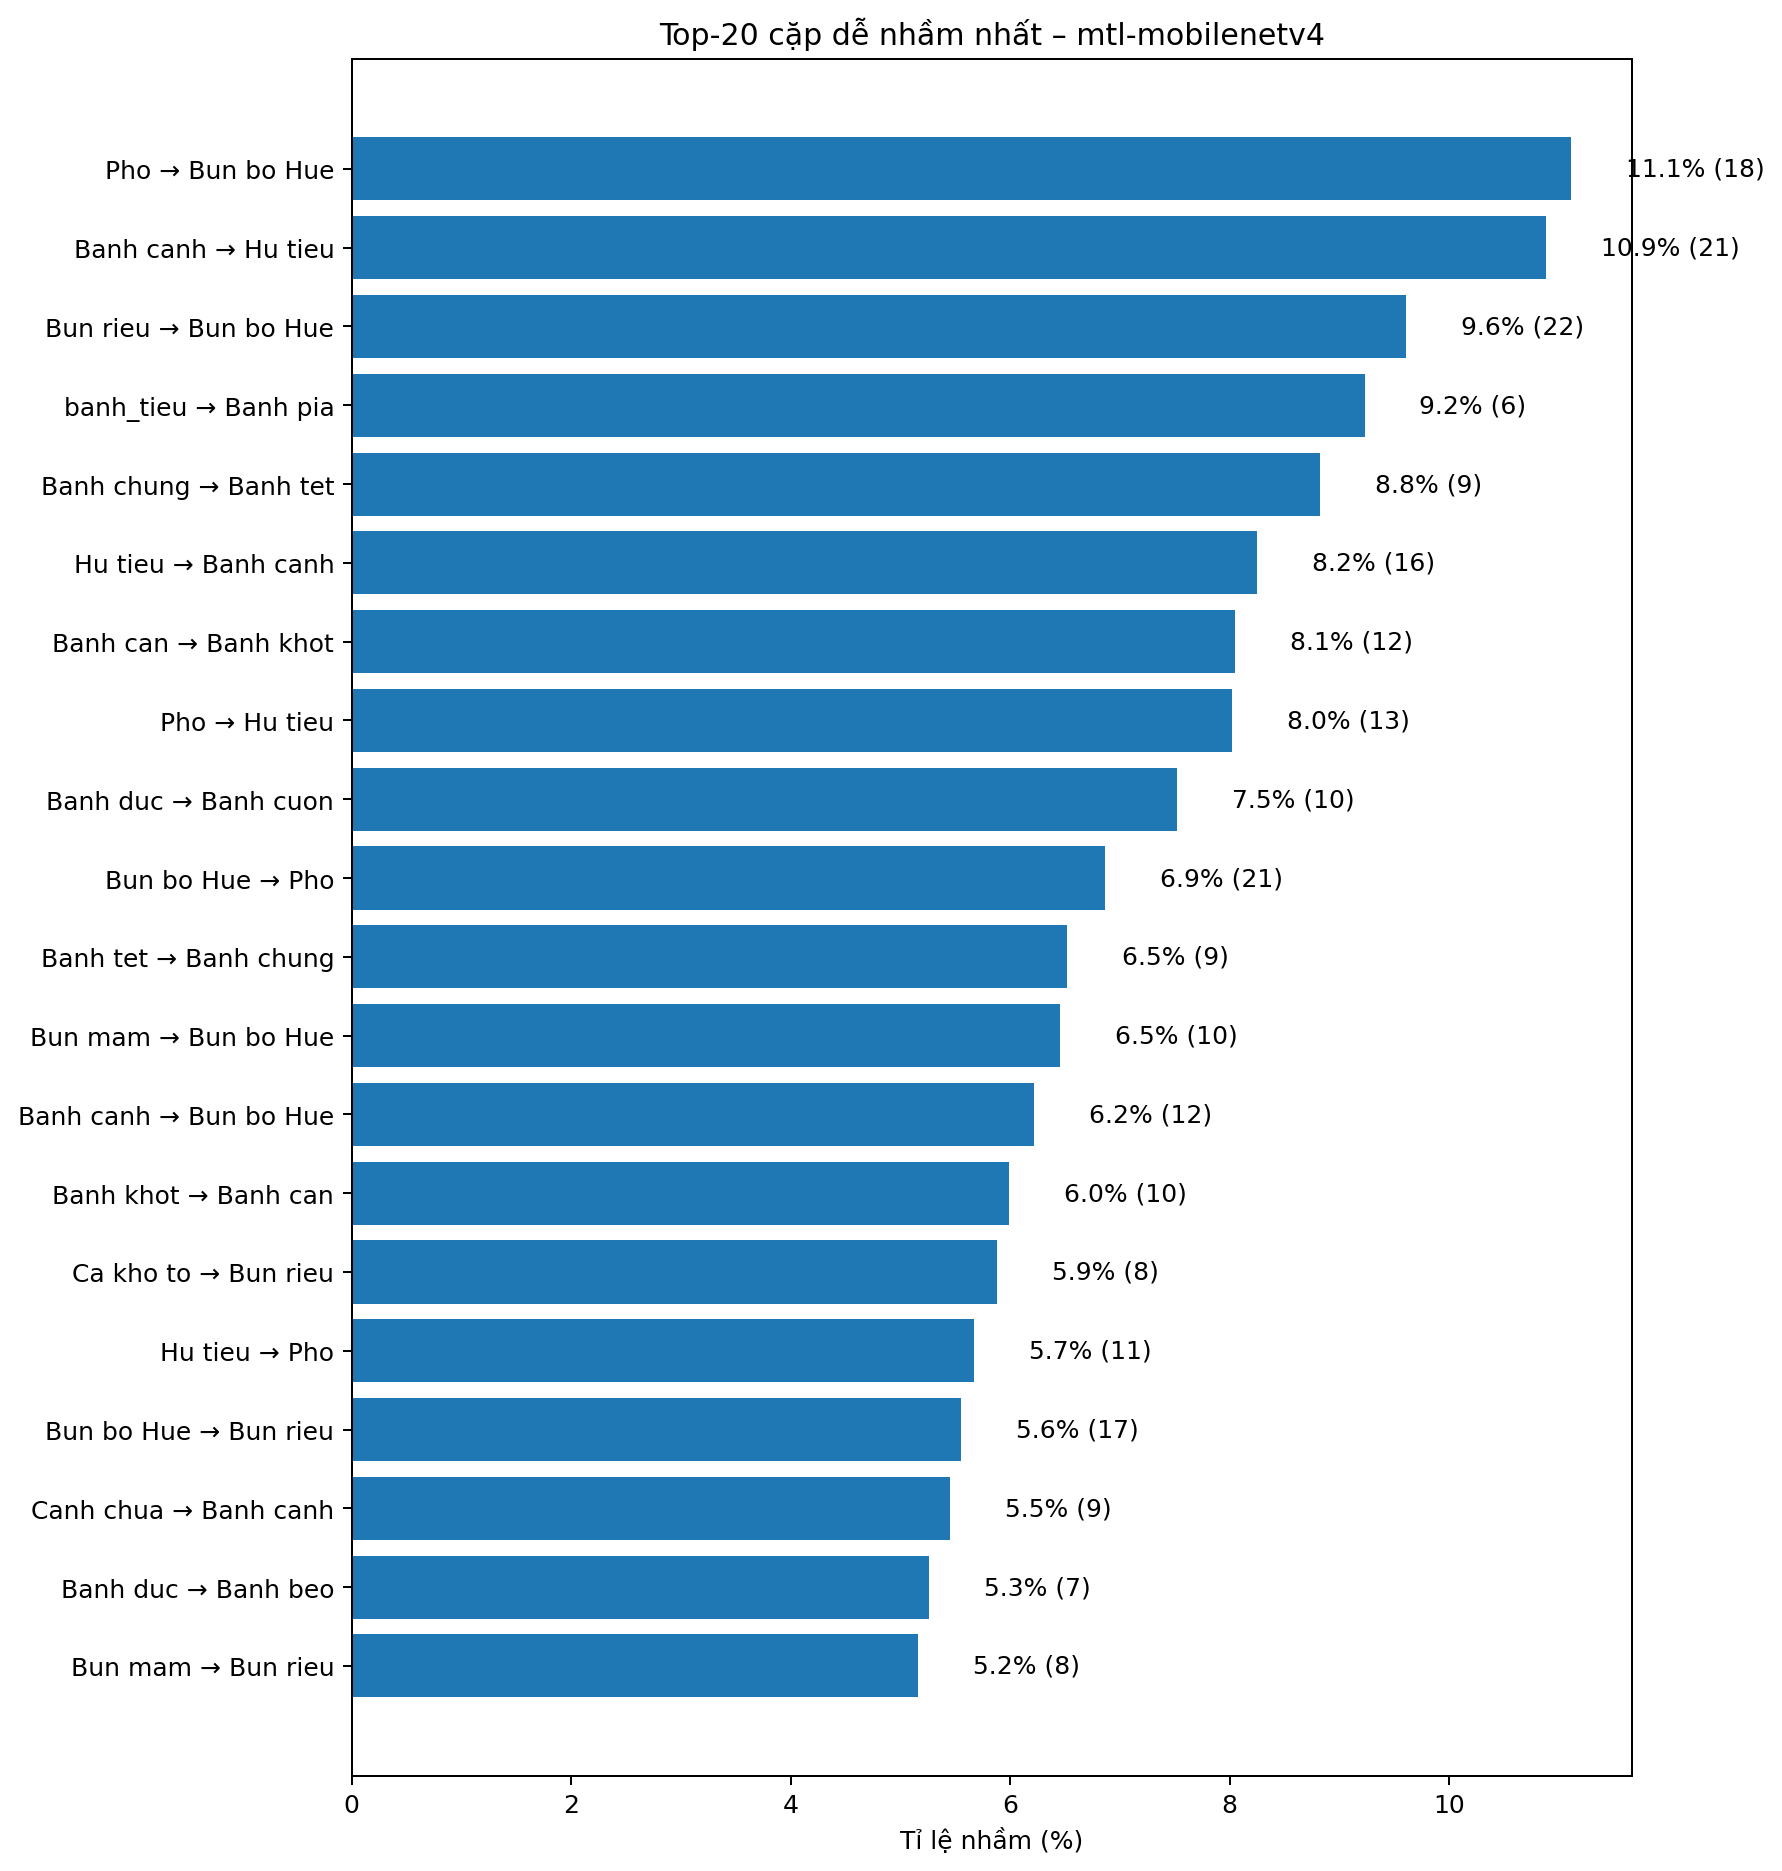

✓ Saved: ./images\mtl-mobilenetv4_top20_confused.png


,run,acc,precision,recall,f1,img_size,batch_size
2,mtl-efficientnet_b0,0.851788,0.851761,0.852588,0.850612,224,64
3,mtl-mobilenetv4,0.812584,0.815148,0.812428,0.812238,224,64
1,mtl-cnn,0.432014,0.434263,0.434682,0.430581,224,64
0,miniCNN,0.033850,0.001026,0.030303,0.001984,224,64


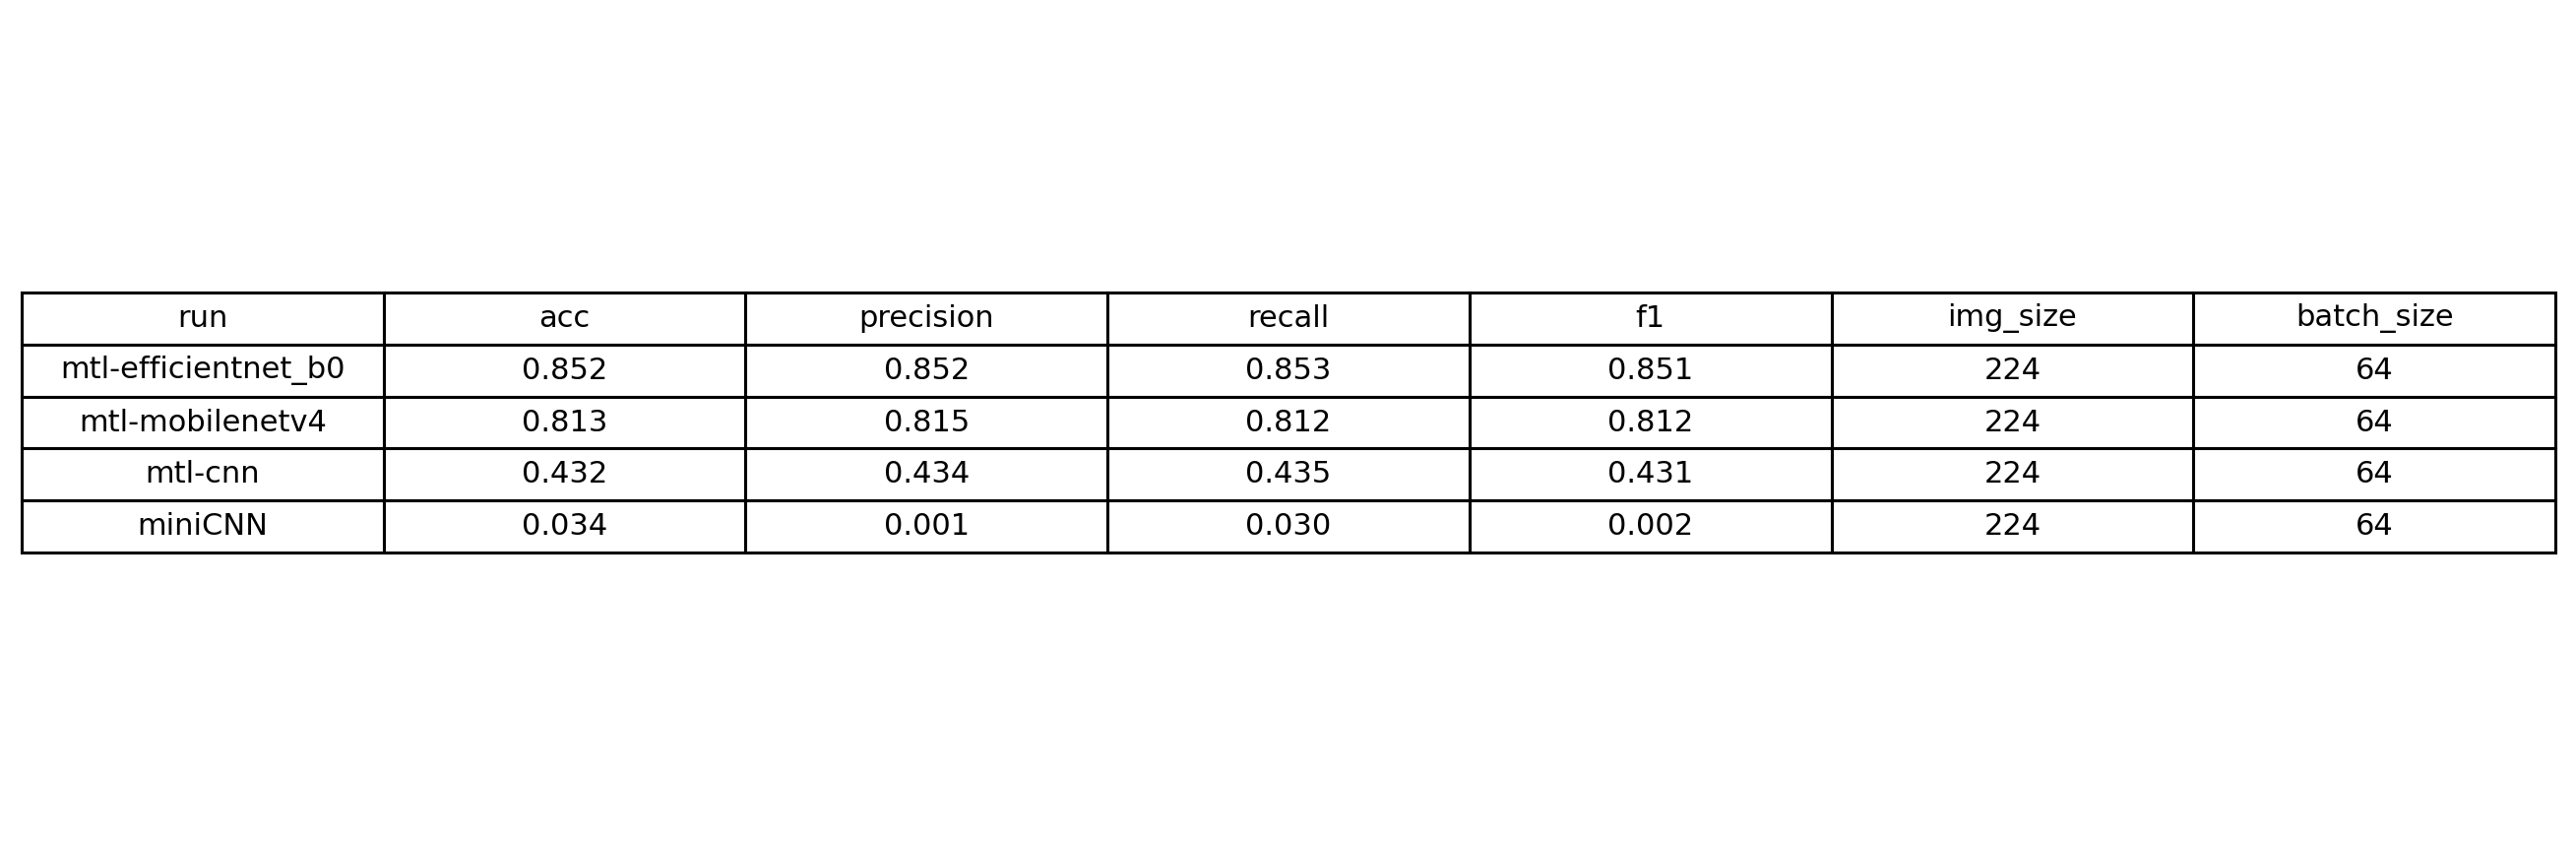

✓ Saved: ./images\summary_models.png


In [115]:
# === CELL 103: Đánh giá toàn bộ mô hình trong thư mục cha Runs/ ===
evaluate_entry(RUNS_DIR)

→ Vẽ lịch sử: miniCNN


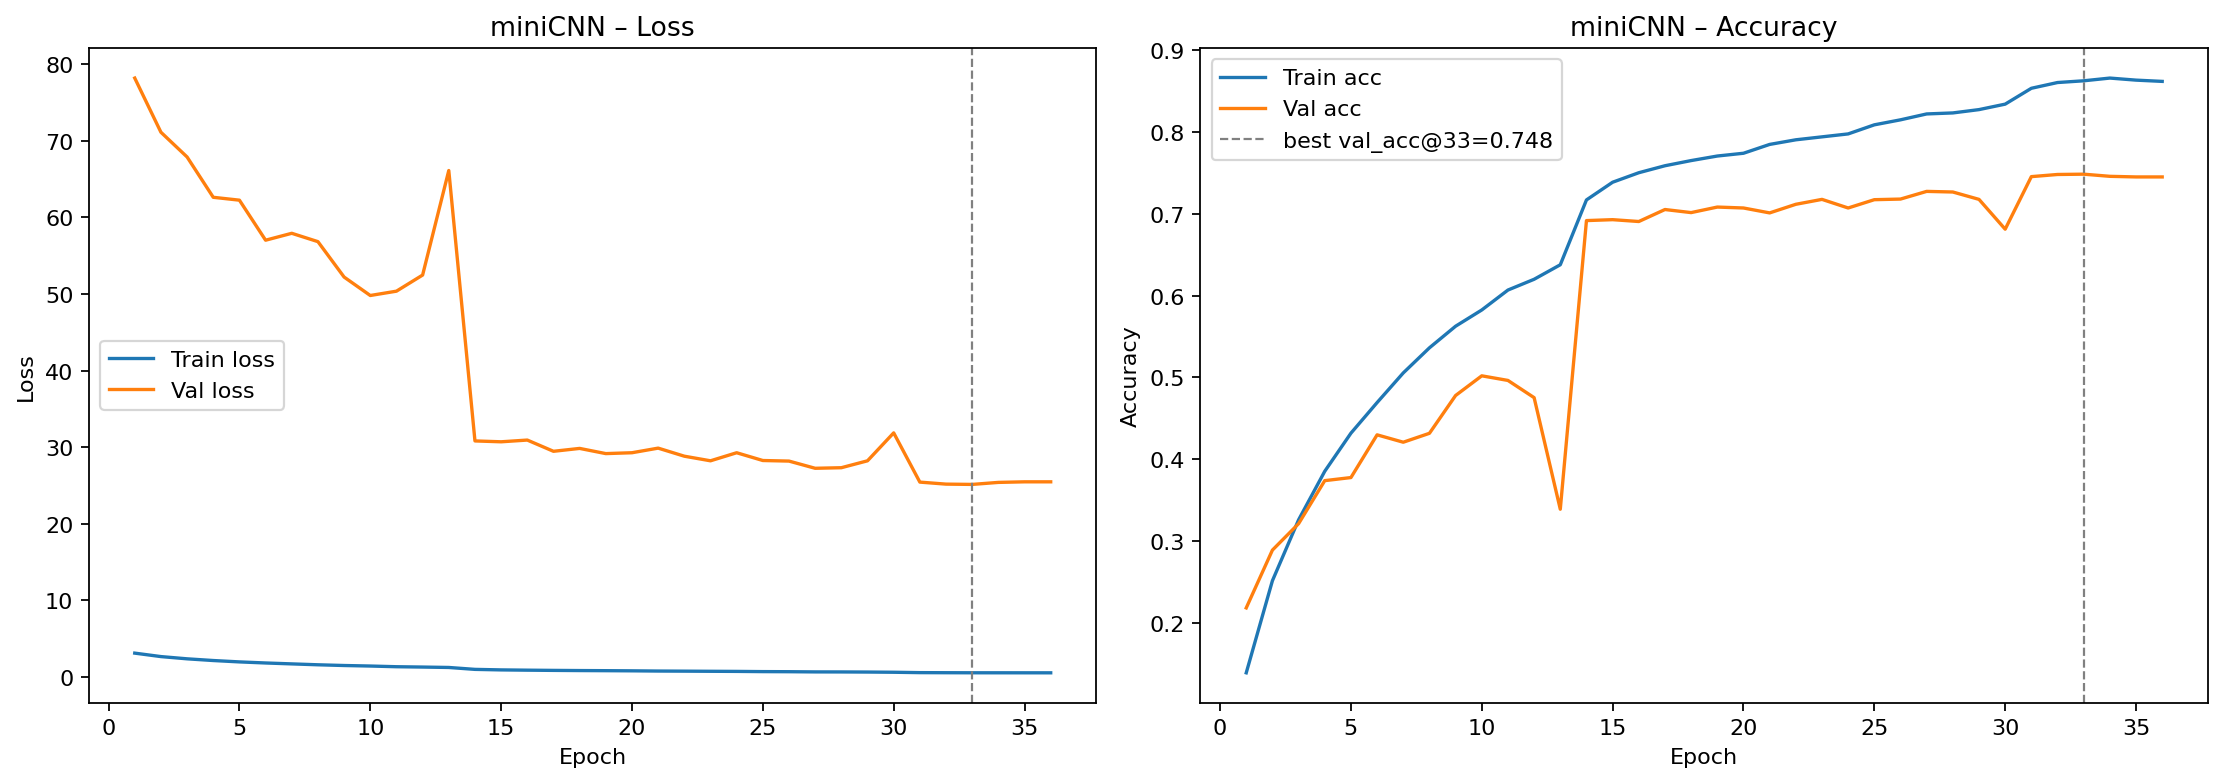

✓ Đã lưu: ./images\miniCNN_history.png
→ Vẽ lịch sử: mtl-cnn


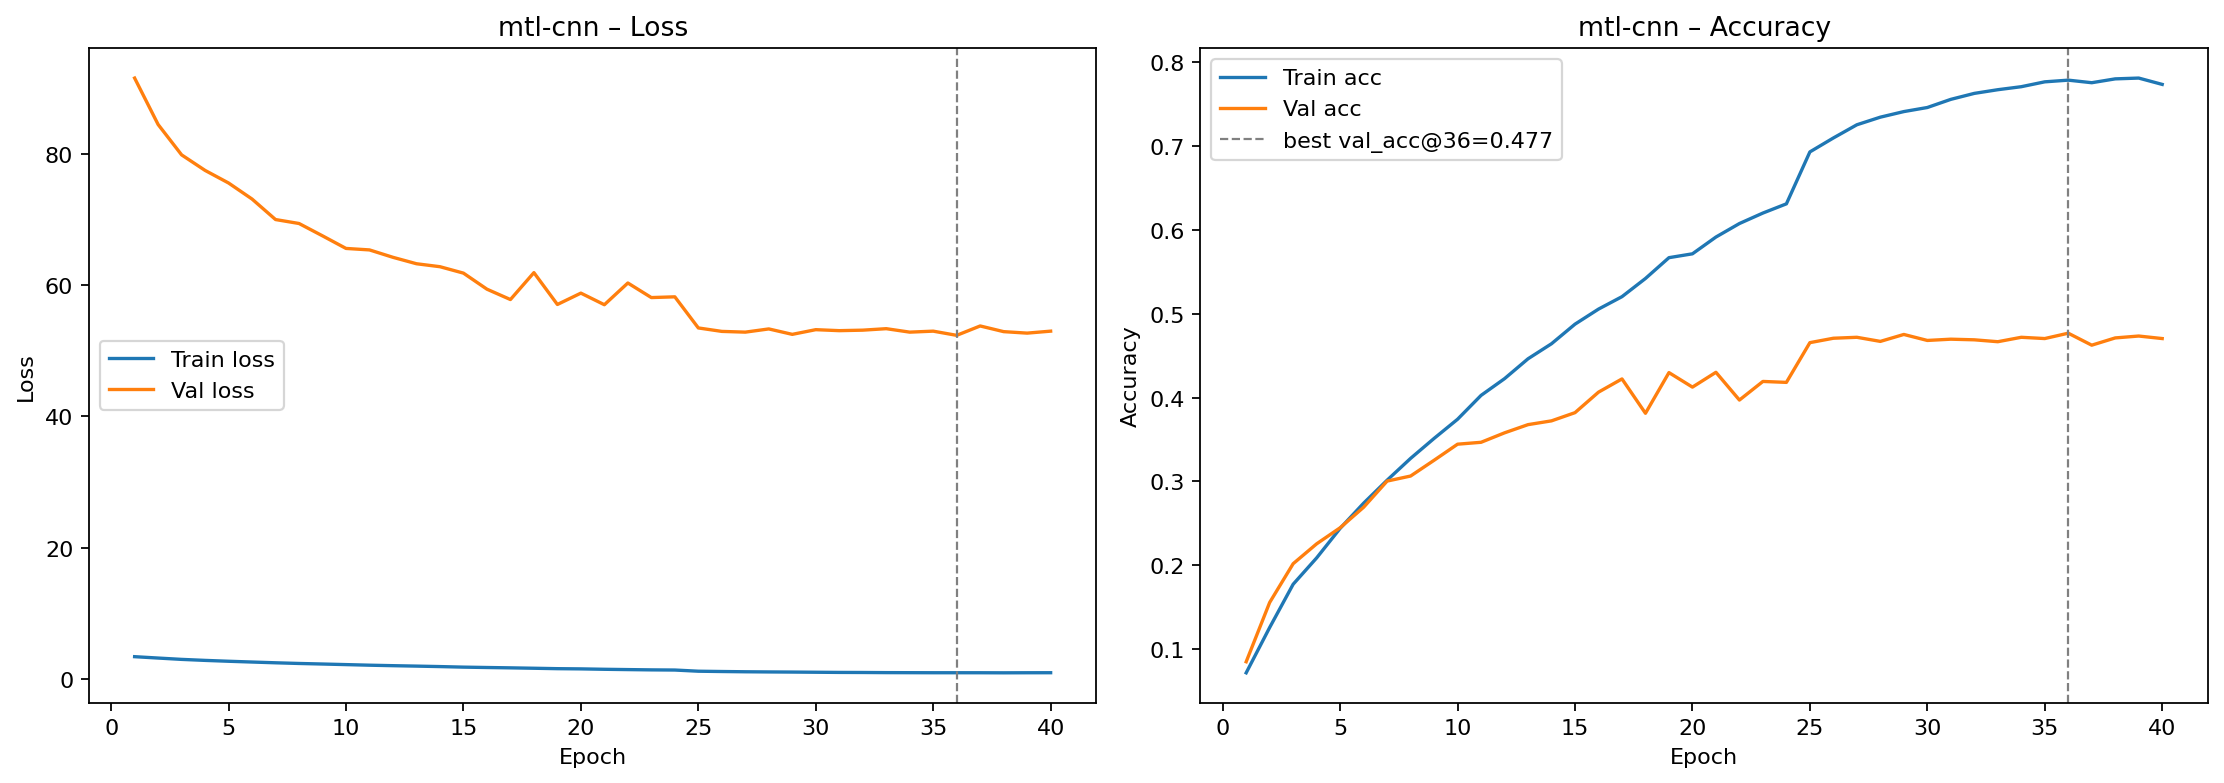

✓ Đã lưu: ./images\mtl-cnn_history.png
→ Vẽ lịch sử: mtl-efficientnet_b0


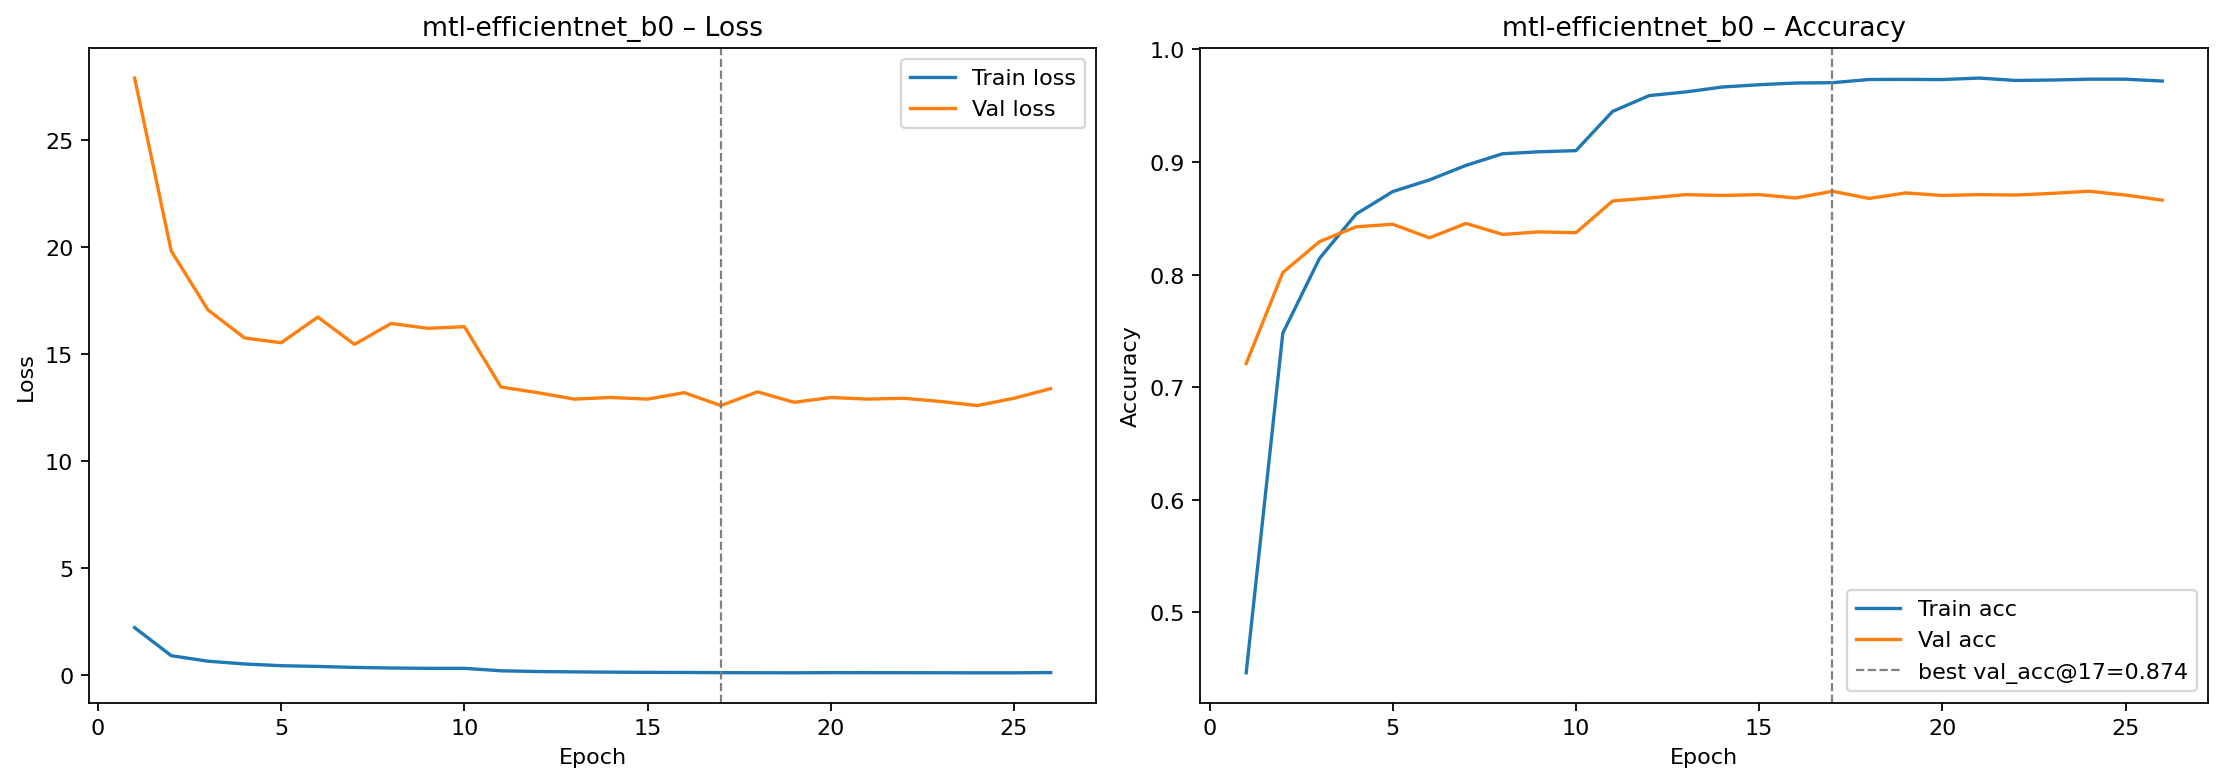

✓ Đã lưu: ./images\mtl-efficientnet_b0_history.png
→ Vẽ lịch sử: mtl-mobilenetv4


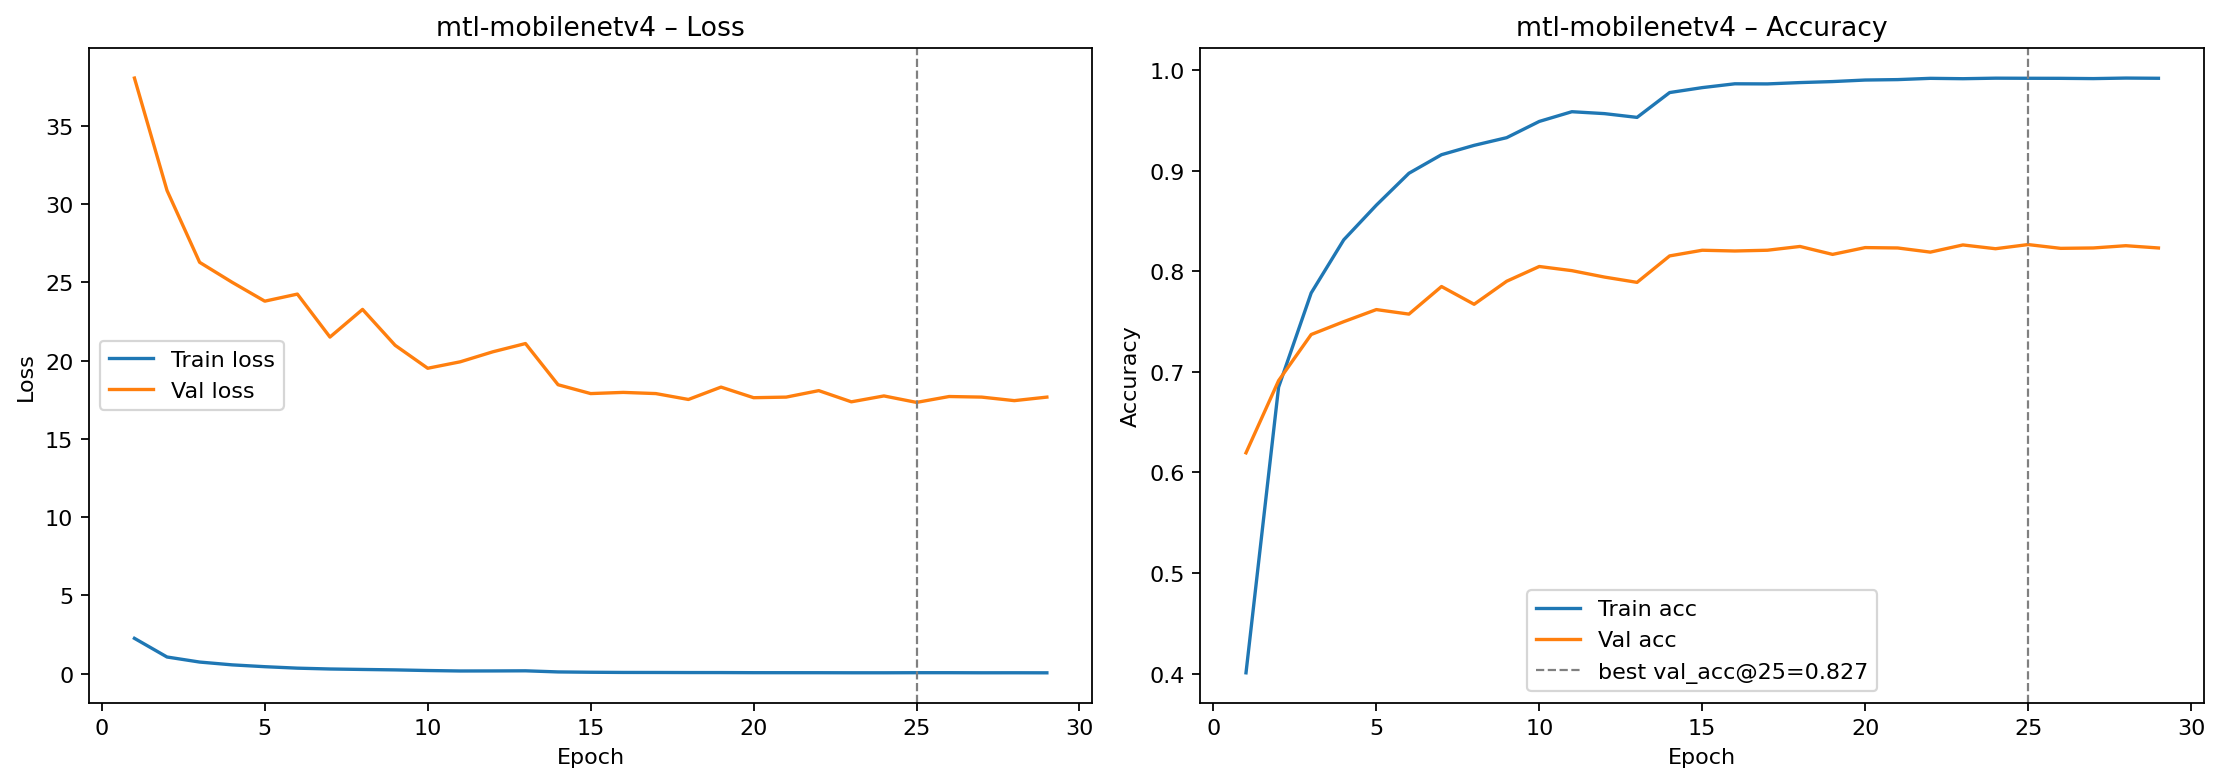

✓ Đã lưu: ./images\mtl-mobilenetv4_history.png


In [116]:
# ==== CELL 9 (REPLACE): Vẽ Loss/Accuracy CHO TẤT CẢ CÁC RUNS ====
def pick_col(df, pats):
    """Chọn cột đầu tiên khớp pattern (không phân biệt hoa/thường)."""
    pats = [p.lower() for p in pats]
    for c in df.columns:
        cl = c.lower()
        if any(re.search(p, cl) for p in pats):
            return c
    return None

def plot_history_for_run(run_path, run_name):
    # 1) tìm file log hợp lệ
    for cand in ["history.csv", "history.json", "train_log.csv", "metrics.csv"]:
        hp = os.path.join(run_path, cand)
        if os.path.isfile(hp):
            hist_path = hp
            break
    else:
        print(f"[-] {run_name}: không thấy history.(csv|json)")
        return

    # 2) đọc log và chuẩn hoá cột
    if hist_path.endswith(".json"):
        df = pd.read_json(hist_path)
    else:
        df = pd.read_csv(hist_path)
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # 3) epoch thực tế trong file; nếu không có cột epoch thì mặc định 1..len
    c_epoch = pick_col(df, [r"^epoch$", r"^epochs?$"])
    epoch = df[c_epoch].to_numpy() if c_epoch else np.arange(1, len(df)+1)

    # 4) bắt các cột loss/acc “mềm”
    c_tr_loss = pick_col(df, [r"^loss$", r"train.*loss"])
    c_va_loss = pick_col(df, [r"val.*loss", r"valid.*loss"])
    c_tr_acc  = pick_col(df, [r"^acc$", r"accuracy$", r"train.*acc", r"train.*accuracy"])
    c_va_acc  = pick_col(df, [r"val.*acc", r"val.*accuracy", r"valid.*acc", r"valid.*accuracy"])

    tr_loss = df[c_tr_loss].to_numpy() if c_tr_loss else None
    va_loss = df[c_va_loss].to_numpy() if c_va_loss else None
    tr_acc  = df[c_tr_acc].to_numpy()  if c_tr_acc  else None
    va_acc  = df[c_va_acc].to_numpy()  if c_va_acc  else None

    # 5) epoch tốt nhất để annotate
    best_ep, note = None, ""
    if va_acc is not None and len(va_acc) > 0:
        best_ep = int(epoch[np.nanargmax(va_acc)])
        note = f"best val_acc@{best_ep}={np.nanmax(va_acc):.3f}"
    elif va_loss is not None and len(va_loss) > 0:
        best_ep = int(epoch[np.nanargmin(va_loss)])
        note = f"best val_loss@{best_ep}={np.nanmin(va_loss):.3f}"

    # 6) vẽ 2 subplot
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=160)

    # Loss
    if tr_loss is not None: ax[0].plot(epoch, tr_loss, label="Train loss")
    if va_loss is not None: ax[0].plot(epoch, va_loss, label="Val loss")
    if best_ep is not None: ax[0].axvline(best_ep, ls="--", lw=1, c="gray")
    ax[0].set_title(f"{run_name} – Loss")
    ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].legend()

    # Accuracy
    if tr_acc is not None: ax[1].plot(epoch, tr_acc, label="Train acc")
    if va_acc is not None: ax[1].plot(epoch, va_acc, label="Val acc")
    if best_ep is not None:
        ax[1].axvline(best_ep, ls="--", lw=1, c="gray", label=note if va_acc is not None else None)
    ax[1].set_title(f"{run_name} – Accuracy")
    ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Accuracy"); ax[1].legend()

    plt.tight_layout()
    out_png = os.path.join(IMAGES_DIR, f"{run_name}_history.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✓ Đã lưu: {out_png}")

# 🔁 DUYỆT HẾT TẤT CẢ RUNS và vẽ
if not os.path.isdir(RUNS_DIR):
    print(f"Thư mục '{RUNS_DIR}' không tồn tại.")
else:
    for run_name in sorted(os.listdir(RUNS_DIR)):
        run_path = os.path.join(RUNS_DIR, run_name)
        if not os.path.isdir(run_path):
            continue
        print(f"→ Vẽ lịch sử: {run_name}")
        plot_history_for_run(run_path, run_name)
